<a href="https://colab.research.google.com/github/Qiustander/Simple_MCMC_tasks/blob/main/MCMC_For_Normal_Distribution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Dependencies & Prerequisites

<div class="alert alert-success">
    Tensorflow Probability is part of the colab default runtime, <b>so you don't need to install Tensorflow or Tensorflow Probability if you're running this in the colab</b>.
    <br>
    If you're running this notebook in Jupyter on your own machine (and you have already installed Tensorflow), you can use the following
    <br>
      <ul>
    <li> For the most recent stable TFP release: <code>pip3 install -q --upgrade tensorflow-probability</code></li>
    <li> For the most recent stable GPU-connected version of TFP: <code>pip3 install -q --upgrade tensorflow-probability-gpu</code></li>
In summary, if you are running this in a Colab, Tensorflow and TFP are already installed
</div>

#### References:
[1] Bayesian Data Analysis 3rd

[2] [Several MCMC convergence tools](https://colab.research.google.com/github/bebi103b/bebi103b.github.io/blob/master/lessons/16/mcmc_diagnostics.ipynb#scrollTo=0chfn87t4plw)

[3] [TFP MCMC case study](https://www.tensorflow.org/probability/examples/TensorFlow_Probability_Case_Study_Covariance_Estimation#choose_some_parameter_values)

In [1]:
#@title Imports and Global Variables  { display-mode: "form" }
"""Import necessary packages and set global variables
"""
!pip3 install -q pandas_datareader
!pip3 install -q wget
!pip3 install statsmodels
from __future__ import absolute_import, division, print_function

import numpy as np
import os
import statsmodels.api as sm
#@markdown This sets the styles of the plotting (default is styled like plots from [FiveThirtyeight.com](https://fivethirtyeight.com/))
matplotlib_style = 'fivethirtyeight' #@param ['fivethirtyeight', 'bmh', 'ggplot', 'seaborn', 'default', 'Solarize_Light2', 'classic', 'dark_background', 'seaborn-colorblind', 'seaborn-notebook']
import matplotlib as mpl
import matplotlib.pyplot as plt; plt.style.use(matplotlib_style)
import matplotlib.axes as axes;
from matplotlib.patches import Ellipse
from mpl_toolkits.mplot3d import Axes3D
import pandas_datareader.data as web
%matplotlib inline
import seaborn as sns; sns.set_context('notebook')
from IPython.core.pylabtools import figsize
#@markdown This sets the resolution of the plot outputs (`retina` is the highest resolution)
notebook_screen_res = 'retina' #@param ['retina', 'png', 'jpeg', 'svg', 'pdf']
%config InlineBackend.figure_format = notebook_screen_res

import tensorflow as tf

# Eager Execution
#@markdown Check the box below if you want to use [Eager Execution](https://www.tensorflow.org/guide/eager)
#@markdown Eager execution provides An intuitive interface, Easier debugging, and a control flow comparable to Numpy. You can read more about it on the [Google AI Blog](https://ai.googleblog.com/2017/10/eager-execution-imperative-define-by.html)
use_tf_eager = False #@param {type:"boolean"}

# Use try/except so we can easily re-execute the whole notebook.
if use_tf_eager:
    try:
        tf.enable_eager_execution()
    except:
        pass

import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors


def session_options(enable_gpu_ram_resizing=True, enable_xla=True):
    """
    Allowing the notebook to make use of GPUs if they're available.

    XLA (Accelerated Linear Algebra) is a domain-specific compiler for linear
    algebra that optimizes TensorFlow computations.
    """
    config = tf.ConfigProto()
    config.log_device_placement = True
    if enable_gpu_ram_resizing:
        # `allow_growth=True` makes it possible to connect multiple colabs to your
        # GPU. Otherwise the colab malloc's all GPU ram.
        config.gpu_options.allow_growth = True
    if enable_xla:
        # Enable on XLA. https://www.tensorflow.org/performance/xla/.
        config.graph_options.optimizer_options.global_jit_level = (
            tf.OptimizerOptions.ON_1)
    return config

def credible_interval(posterior_dist, alpha=0.05):
    """
    Compute the credible interval for a set of samples.

    Parameters:
    - posterior_dist: array-like, the set of samples
    - alpha: float, desired significance level (e.g., 0.05 for 95% credible interval)

    Returns:
    - tuple containing the lower and upper bounds of the credible interval
    """
    sorted_samples = np.sort(posterior_dist)
    lower_bound = np.percentile(sorted_samples, 100 * alpha / 2)
    upper_bound = np.percentile(sorted_samples, 100 * (1 - alpha / 2))

    return (lower_bound, upper_bound)


from tensorflow_probability.python.mcmc import RandomWalkMetropolis
from tensorflow_probability.python.mcmc import HamiltonianMonteCarlo
from tensorflow_probability.python.mcmc import sample_chain

# Get TensorFlow version.
print(f'TnesorFlow version: {tf.__version__}')
print(f'TnesorFlow Probability version: {tfp.__version__}')


  Preparing metadata (setup.py) ... done
TnesorFlow version: 2.12.0
TnesorFlow Probability version: 0.20.1


# MCMC For Fitting 1D Normal Distribution

We have $N$ points observed data: $p(x_i|\mu, σ^2) \sim \mathcal{N}(\mu, σ^2), i = 1, \dots, N$, where $\mu \in \mathbb{R}$ or $σ^2 \in \mathbb{R}_+$ maybe unknown. $x_i$ denotes $n$-th data sample.

Problem:
1. estimate $p(\mu|x,\sigma^2) ∝ \pi(\mu)l(x|\mu, \sigma^2)$
2. estimate $p(\sigma^2|x,\mu) ∝ \pi(\sigma^2)l(x|\mu, \sigma^2)$
3. estimate $p(\sigma^2, \mu|x) ∝ \pi(\mu)\pi(\sigma^2)l(x|\mu, \sigma^2)$,

where $\pi(\cdot)$ is the prior distribution and $l(\cdot)$ denotes the data likelihood.

We generate sample data from a normal distribution using TensorFlow Probability Distributions.

In [2]:
# Set seed
seed = 50
tf.random.set_seed(seed=seed)
# Number of samples.
n = 100
# True parameters
true_mean = tf.constant([1.2])
true_std = tf.constant([[0.5]])

# Define Normal distribution with the true parameters, event_shape:1,
normal_true = tfd.MultivariateNormalTriL(loc=true_mean,
                                          scale_tril=true_std)
# Generate samples.
observations = normal_true.sample(sample_shape=n)
sample_mean = tf.reduce_mean(observations)
sample_std = tf.math.reduce_std(observations)

print(f'sample mean: {sample_mean}')
print(f'sample std: {sample_std}')

PRIOR_MEAN = tf.constant([1.0])
PRIOR_STD = tf.constant([[0.8]])
PRIOR_INV_GAMMA_ALPHA = tf.constant([2.0])
PRIOR_INV_GAMMA_BETA= tf.constant([2.0])


sample mean: 1.2280840873718262
sample std: 0.518873929977417


## Estimation of unknown $\mu$, given $\sigma^2$

First of all, define a prior distribution which represents the belief for $\mu$.

Define $\pi(\mu) \sim \mathcal{N}(\mu_0, \sigma_0^2)$, where $\sigma_0^2 =\sigma^2$ since it is known, and let $\mu_0 = \hat{\mu}$ which is the sample mean.

Data likelihood function $l(x|\mu, \sigma^2) = \prod_{i=1} \mathcal{N}(x_i| \mu, \sigma^2)$.

Therefore, the posterior distribution $p(\mu|\sigma^2, x) ∝ l(x|\mu, \sigma^2)\pi(\mu)$ is still a Gaussian distribution, it is actually the conjugate prior to the prior distribution. In practice, we apply $\log$  likelihood and prior distribution such that we just need  addition instead of product which may result in underflow floating point precision.

In [3]:
num_mcmc_samples = 2000
num_burn_in_steps = int(num_mcmc_samples//3)
# The number of chains is determined by the shape of the initial values.
# Here we'll generate N_CHAINS chains, so we'll need a tensor of N_CHAINS initial values.
N_CHAINS = 8

# Replicate the observations for each chain
replicate_observations = tf.tile(tf.expand_dims(observations, axis=1), multiples=[1, N_CHAINS, 1])

In [4]:

"""
define prior distribution
"""
def prior_dist(parameter):
  return tfd.Normal(loc=PRIOR_MEAN,
                                  scale=PRIOR_STD).log_prob(parameter)

"""
define target distribution
"""
def posterior_dist(observations):
    def _compute_posterior(parameter):
        return tf.reduce_sum(tfd.MultivariateNormalTriL(loc=parameter,
                                                        scale_tril=sample_std[tf.newaxis, tf.newaxis]).log_prob(observations), axis=0)[..., tf.newaxis] \
                                                        + prior_dist(parameter)

    return _compute_posterior

"""
Sampling
"""
init_state = tf.random.normal([N_CHAINS, 1])

@tf.function
def run_metropolis_hasting():
  mh_kernel = RandomWalkMetropolis(posterior_dist(replicate_observations),
                                    new_state_fn=tfp.mcmc.random_walk_normal_fn(scale=0.2))

  states, kernels_results = sample_chain(num_results=num_mcmc_samples,
                                        current_state=init_state, #constant start
                                        num_burnin_steps=num_burn_in_steps,
                                        num_steps_between_results=0,
                                        kernel=mh_kernel,
                                        seed=seed)
  return states, kernels_results

@tf.function
def run_hmc():
  hmc_kernel = HamiltonianMonteCarlo(posterior_dist(replicate_observations),
                                    step_size=0.05,
                                    num_leapfrog_steps=2)

  states, kernels_results = sample_chain(num_results=num_mcmc_samples,
                                        current_state=init_state, #constant start
                                        num_burnin_steps=num_burn_in_steps,
                                        kernel=hmc_kernel,
                                        seed=seed)

  return states, kernels_results

mh_states, mh_results = run_metropolis_hasting()
hmc_states, hmc_results = run_hmc()

mh_states = tf.squeeze(mh_states, axis=[-1]).numpy()
hmc_states = tf.squeeze(hmc_states, axis=[-1]).numpy()



/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/mcmc/sample.py:339: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '
/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/mcmc/sample.py:339: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '


#### Analytical Posterior Distribution

Assume that given $\sigma^2$, define the prior of the $\mu$ as the $\pi(\mu) \sim \mathcal{N}(\mu_0, \sigma_0^2)$, the posterior distribution of $\mu$ is also a Normal distribution that has the analytical form:
$\mathcal{N}\left(\frac{1}{\frac{1}{\sigma_0^2}+\frac{n}{\sigma^2}}\left(\frac{\mu_0}{\sigma_0^2}+\frac{\sum_{i=1}^n x_i}{\sigma^2}\right),\left(\frac{1}{\sigma_0^2}+\frac{n}{\sigma^2}\right)^{-1}\right)$

In [5]:
coeff = 1/PRIOR_STD**2 + observations.shape[0]/sample_std**2

true_posterior_mean = 1/coeff*(tf.reduce_sum(observations)/sample_std**2 + PRIOR_MEAN/PRIOR_STD**2)
true_posterior_std = tf.sqrt(1/coeff)

### Diagnostics for MCMC sampler

Tensorflow probability provides various diagnostic tools to check the convergence of the chain.

#### The Gelman-Rubin R-hat statistic

The **Gelman-Rubin R-hat statistic** is a useful metric to determine if we have achieved stationarity with our chains. The idea is that we run multiple chains in parallel (at least four). For a given parameter, we then compute the variance in the samples *between* the chains, and then the variance of samples *within* the chains. The ratio of these two is the Gelman-Rubin R-hat statistic, usually denoted as $\hat{R}$, and we compute $\hat{R}$ for each chain.

\begin{align}
\hat{R} = \frac{\text{variance between chains}}{\text{variance within chains}}.
\end{align}

The value of $\hat{R}$ approaches unity if the chains are properly sampling the target distribution because the chains should be identical in their sampling of the posterior if they have all reached the limiting distribution. As a rule of thumb, recommended by [Vehtari, et al.](https://arxiv.org/abs/1903.08008), the value of $\hat{R}$ should be less than 1.01, but of course this is problem-dependent.

The R-hat statistic can be found in *tfp.mcmc.potential_scale_reduction*.

In [6]:
r_hat_mh = tfp.mcmc.potential_scale_reduction(
    mh_states,
    independent_chain_ndims=1,
    split_chains=True)
r_hat_hmc = tfp.mcmc.potential_scale_reduction(
    hmc_states,
    independent_chain_ndims=1,
    split_chains=True)

print(f"R^hat for MH algorithm {r_hat_mh}")
print(f"R^hat for HMC algorithm {r_hat_hmc}")

R^hat for MH algorithm 1.0029791593551636
R^hat for HMC algorithm 0.9994307160377502


#### Trace Plot

One intuitive and easily implemented diagnostic tool is a traceplot which plots the parameter value per iteration against the iteration number. If the model has converged, the traceplot will move around the *mode* of the distribution. A clear sign of non-convergence with a traceplot occurs when we observe some trending in the sample space.

**Drawback**: it may appear that the chain has converged, however, it trapped (for a finite time) in a local region rather exploring the full posterior.

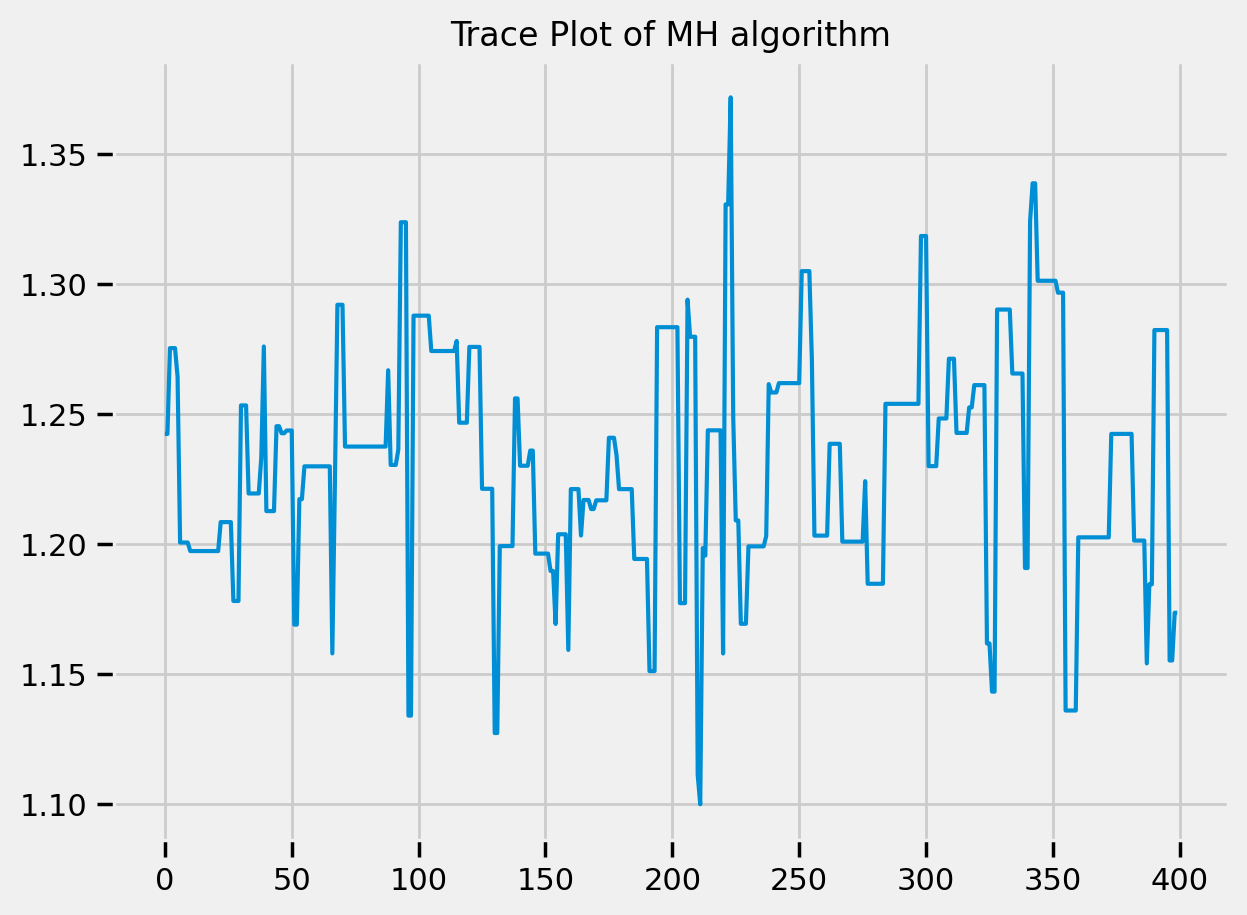

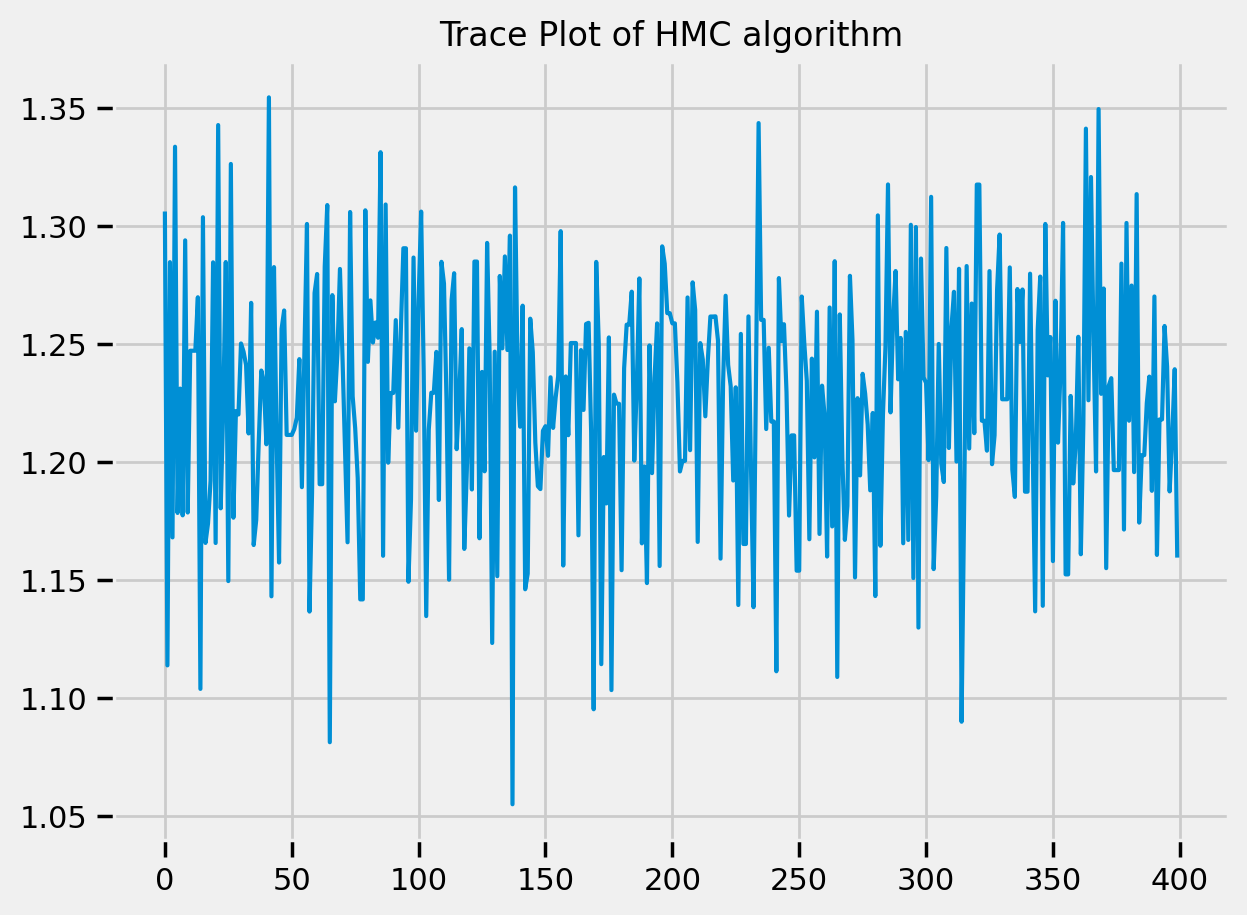

In [7]:
# trace the fist chain
plt.plot(tf.squeeze(mh_states[-num_mcmc_samples//5:, 0]))
plt.title("Trace Plot of MH algorithm")
plt.show()

plt.plot(tf.squeeze(hmc_states[-num_mcmc_samples//5:, 0]))
plt.title("Trace Plot of HMC algorithm")
plt.show()

#### Acceptance rate

In [8]:
accept_rate_mh = tf.math.count_nonzero(mh_results.is_accepted, axis=0)/num_mcmc_samples
accept_rate_hmc = tf.math.count_nonzero(hmc_results.is_accepted, axis=0)/num_mcmc_samples

print(f"Acceptance rate for MH algorithm {accept_rate_mh}")
print(f"Acceptance rate for HMC algorithm {accept_rate_hmc}")

Acceptance rate for MH algorithm [[0.2725]
 [0.295 ]
 [0.2945]
 [0.298 ]
 [0.297 ]
 [0.3205]
 [0.312 ]
 [0.2935]]
Acceptance rate for HMC algorithm [[0.916 ]
 [0.921 ]
 [0.9285]
 [0.926 ]
 [0.9275]
 [0.9265]
 [0.924 ]
 [0.9255]]


#### Effective samples size

Recall that MCMC samplers do not draw independent samples from the target distribution. Rather, the samples are correlated. Ideally, though, we *would* draw independent samples. We would like to get an estimate for the number of *effectively independent* samples we draw. This is referred to either as **effective samples size** (ESS) or number of effective samples ($n_\mathrm{eff}$).

The effective sample size can be found in *tfp.mcmc.effective_sample_size*.

In [9]:
ess_mh = tfp.mcmc.effective_sample_size(
    mh_states,
    cross_chain_dims=None,
)
ess_hmc = tfp.mcmc.effective_sample_size(
    hmc_states,
    cross_chain_dims=None,
)

print(f"Effective sample size for MH algorithm {ess_mh}")
print(f"Effective sample size for HMC algorithm {ess_hmc}")

Effective sample size for MH algorithm [377.60074 415.9672  504.5307  409.32675 417.59033 425.85086 402.73438
 334.51965]
Effective sample size for HMC algorithm [2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000.]


#### Autocorrelation Plot

The lag-k autocorrelation is the correlation between every sample and the sample k steps before. This autocorrelation should become smaller as k increases, i.e. samples can be considered as independent. If, on the other hand, autocorrelation remains high for higher values of k , this indicates a high degree of correlation between samples and slow mixing. If the ACF takes too long to decay to 0, the chain exhibits a high degree of dependence and will tend to get stuck in place.



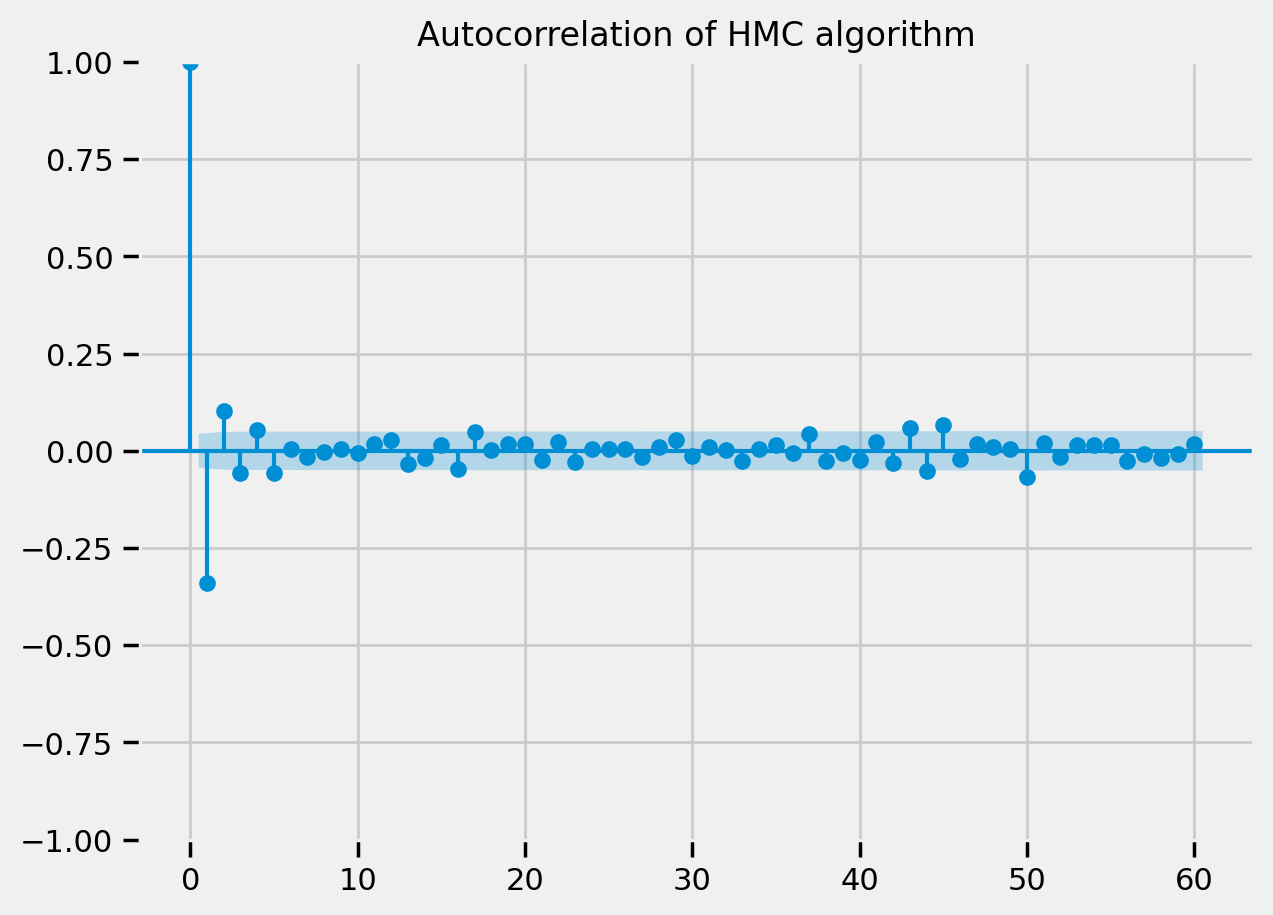

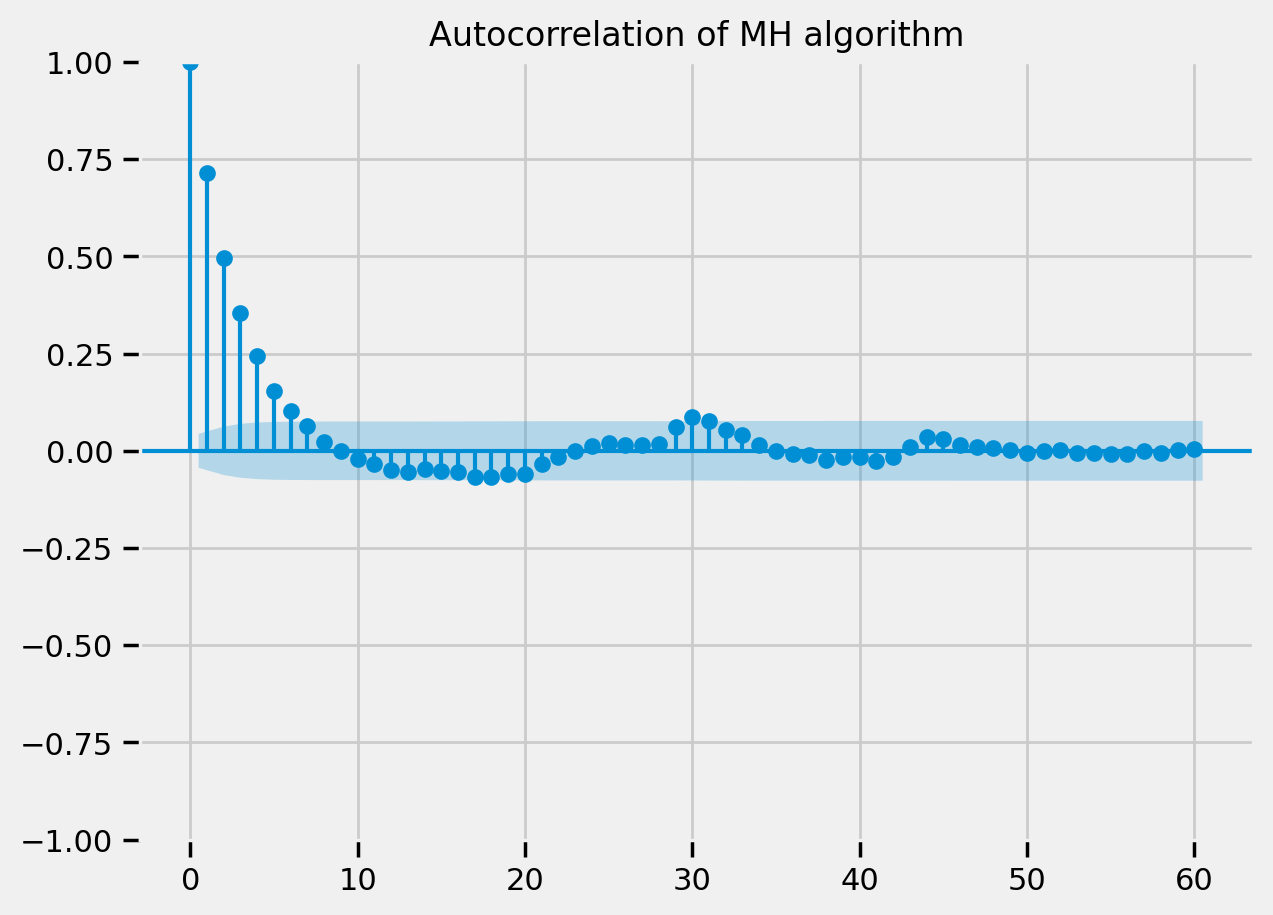

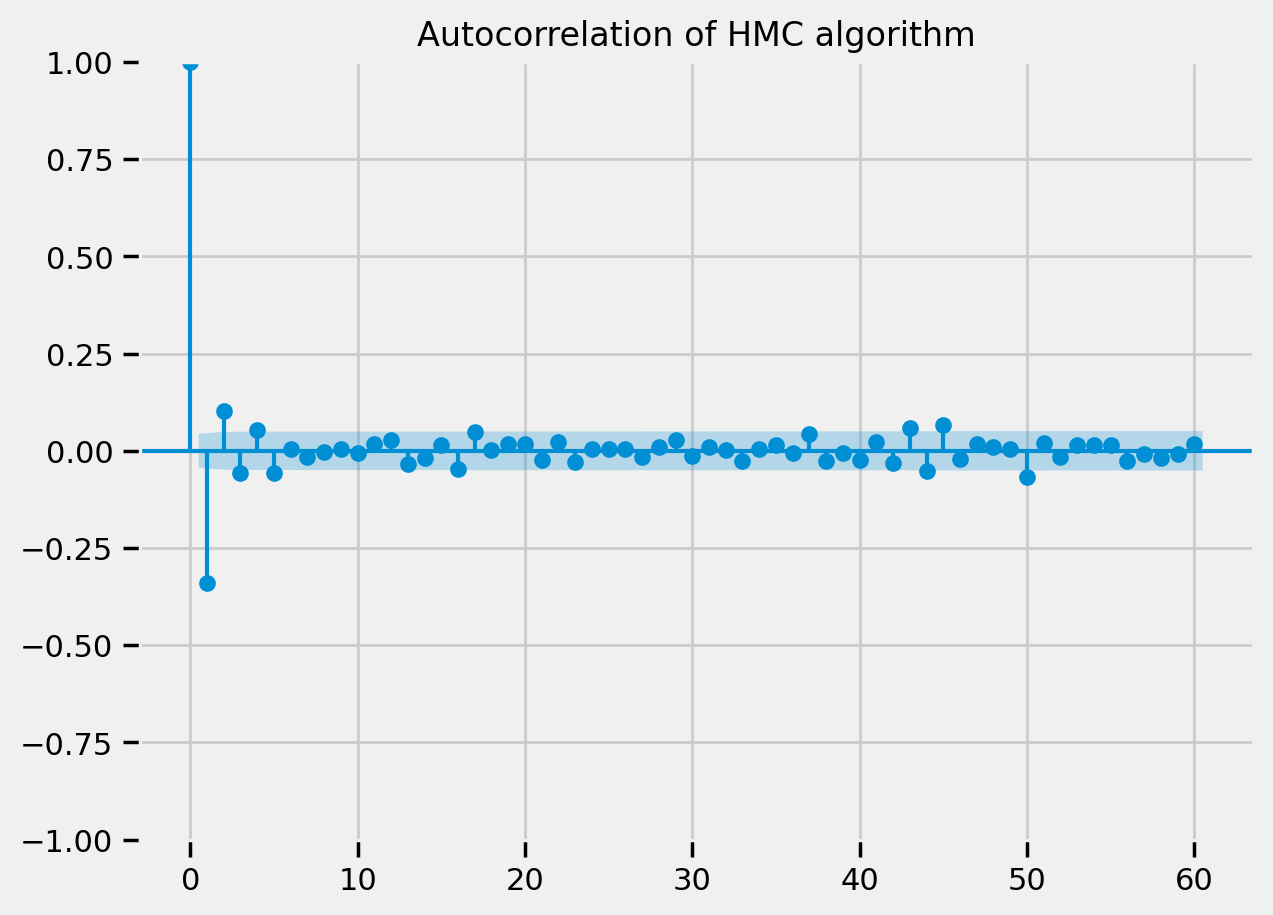

In [10]:
# use the first chain for plotting auto-correlation
sm.graphics.tsa.plot_acf(mh_states[:, 0],
                         title='Autocorrelation of MH algorithm',
                         lags=60)
sm.graphics.tsa.plot_acf(hmc_states[:, 0],
                         title='Autocorrelation of HMC algorithm',
                         lags=60)

#### Posterior Histogram and Credible Interval

It is intuitive to plot the histogram of the posterior distribution to check the convergence. Besides, we can check the credible interval of the samples

<ipython-input-11-2eed1e511676>:18: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(mh_dist, ax=ax, label='Histogram of MH algorithm')


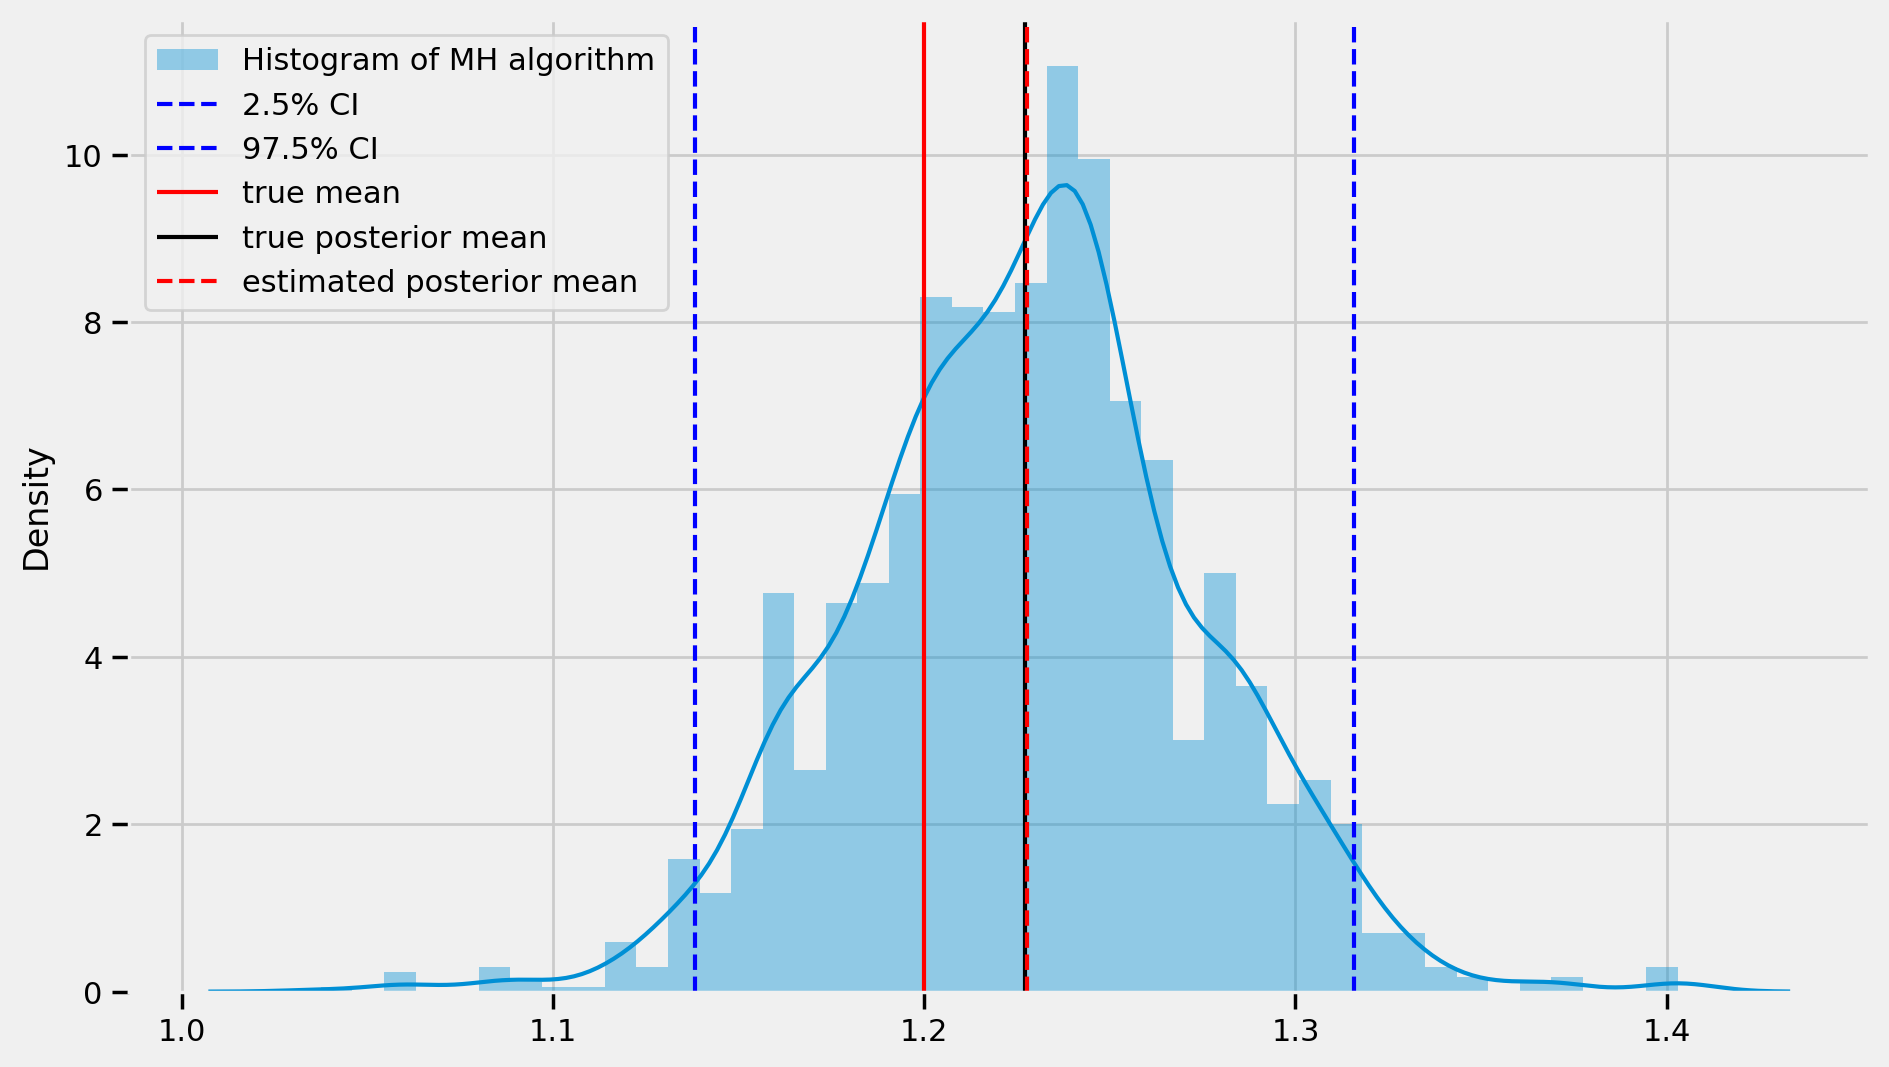

<ipython-input-11-2eed1e511676>:44: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(hmc_dist, ax=ax, label='Histogram of HMC algorithm')


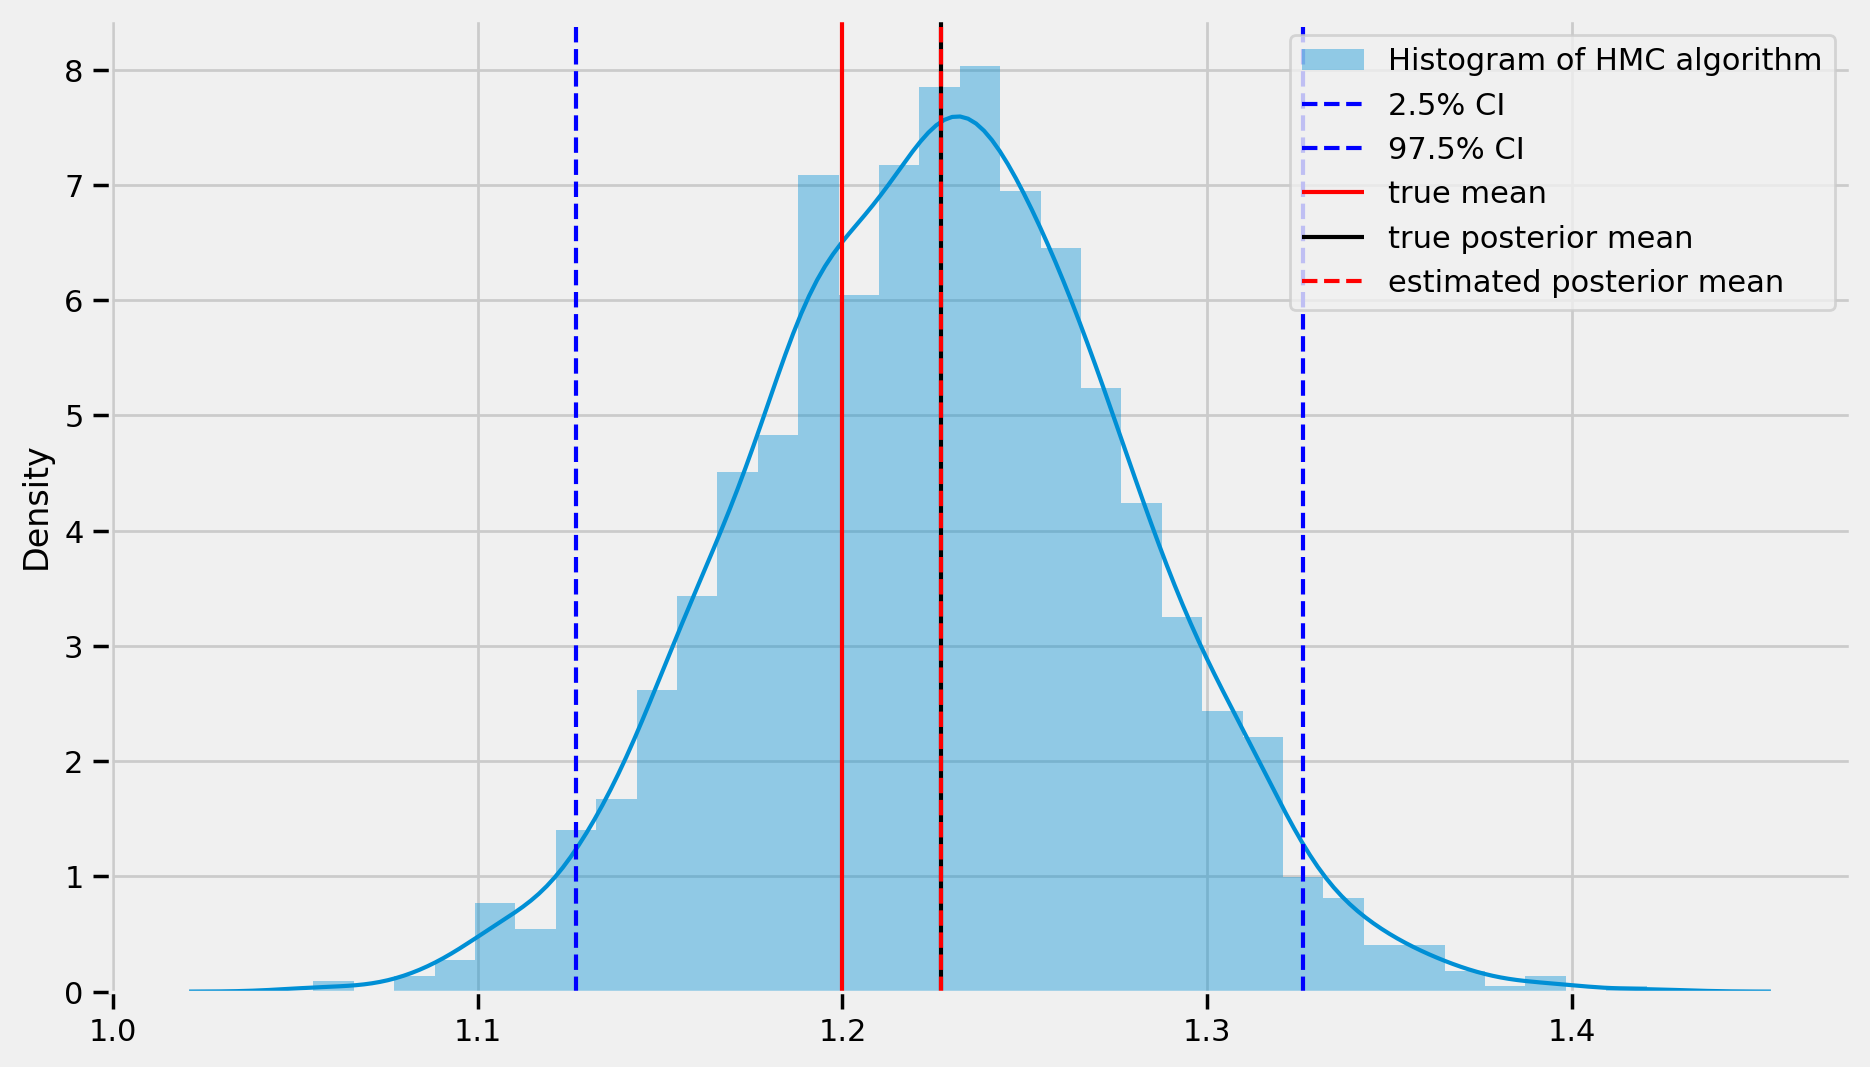

In [11]:
# plot the fist chain

mh_dist = mh_states[:, 0]
hmc_dist = hmc_states[:, 0]

# Scatter plot of data samples and histogram
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
# ax.scatter(
#     mh_dist,
#     np.abs(np.random.randn(mh_dist.size)),
#     zorder=15,
#     color="red",
#     marker="x",
#     alpha=0.5,
#     label="Samples",
# )
sns.distplot(mh_dist, ax=ax, label='Histogram of MH algorithm')
# lines = ax.hist(mh_dist, bins=100, edgecolor="k", label="Histogram of MH algorithm")
ci_mh = credible_interval(mh_dist)
ax.axvline(x=ci_mh[0], color='blue', linestyle='--', label='2.5% CI')
ax.axvline(x=ci_mh[1], color='blue', linestyle='--', label='97.5% CI')
ax.axvline(x=true_mean, color='red', linestyle='-', label='true mean')
ax.axvline(x=true_posterior_mean, color='black', linestyle='-', label='true posterior mean')
ax.axvline(x=np.mean(mh_dist), color='red', linestyle='--', label='estimated posterior mean')

ax.legend(loc="best")
ax.grid(True, zorder=-5)
plt.show()


# Scatter plot of data samples and histogram
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
# ax.scatter(
#     hmc_dist,
#     np.abs(np.random.randn(hmc_dist.size)),
#     zorder=15,
#     color="red",
#     marker="x",
#     alpha=0.5,
#     label="Samples",
# )
sns.distplot(hmc_dist, ax=ax, label='Histogram of HMC algorithm')
# lines = ax.hist(hmc_dist, bins=100, edgecolor="k", label="Histogram of HMC algorithm")
ci_hmc = credible_interval(hmc_dist)
ax.axvline(x=ci_hmc[0], color='blue', linestyle='--', label='2.5% CI')
ax.axvline(x=ci_hmc[1], color='blue', linestyle='--', label='97.5% CI')
ax.axvline(x=true_mean, color='red', linestyle='-', label='true mean')
ax.axvline(x=true_posterior_mean, color='black', linestyle='-', label='true posterior mean')
ax.axvline(x=np.mean(hmc_dist), color='red', linestyle='--', label='estimated posterior mean')

ax.legend(loc="best")
ax.grid(True, zorder=-5)
plt.show()

## Estimation of unknown $\sigma^2$, given $\mu$

First of all, define a prior distribution which represents the belief for $\sigma^2$.

We can define the prior distribution of $\sigma^2$ as the inverse gamma distribution according to the [conjugate prior](https://en.wikipedia.org/wiki/Conjugate_prior). That is, $\pi(\sigma^2) \sim \mathcal{IG}(\alpha, \beta)$.

Data likelihood function $l(x|\mu, \sigma^2) = \prod_{i=1} \mathcal{N}(x_i| \mu, \sigma^2)$.

Therefore, the posterior distribution $p(\sigma^2|\mu, x)$ is a inverse-Gamma distribution, it is actually the conjugate prior to the prior distribution.

#### Sampling In Unconstrainted Space

If we directly define the prior distribution and likelihood distribution, the MCMC sampling would definitely fails. The problem here is that our parameter of interest $\sigma^2$ is a **postive value**. The sampler doesn't know anything about this constraint (except possibly through gradients), so it is entirely possible that the sampler will propose an invalid value, particularly if the step size is large.

There is a straightforward solution to the problem above: we can reparameterize our model such that the new parameters no longer have these constraints. TFP provides a useful set of tools - [bijectors](https://www.tensorflow.org/probability/api_docs/python/tfp/bijectors/Bijector) - for doing just that.

We can deal with the $\sigma^2$ with a simple step to transform it to the unconstrainted space: take the log of the $\sigma^2$. We accomplish this via the inverse of the Exp bijector. Therefore, we can sample the $\theta = \log \sigma^2$, then transform back to original value via $exp(\theta)$ which is always positive.

A even simplier idea to achieve the goal is via the [TransformedTransitionKernel](https://www.tensorflow.org/probability/api_docs/python/tfp/mcmc/TransformedTransitionKernel) which applies a bijector to the MCMC's state space. It wraps the sampler and handles all the conversions. Specifically, with **TransformedTransitionKernel**, the MCMC would automatically maps the $\theta$ to unconstrainted space, do the sampling, and then transforms back to the original space.

In [12]:
init_state = tf.random.uniform([N_CHAINS, 1, 1])

"""
define prior distribution
"""
def prior_dist(parameter):
  return tfd.InverseGamma(concentration=PRIOR_INV_GAMMA_ALPHA,
                                  scale=tf.constant(PRIOR_INV_GAMMA_BETA)).log_prob(parameter)

"""
define target distribution
"""
def posterior_dist(observations):
    def _compute_posterior(parameter):
        return tf.reduce_sum(tfd.MultivariateNormalTriL(loc=sample_mean,
                                                        scale_tril=parameter).log_prob(observations), axis=0)[..., tf.newaxis, tf.newaxis] \
                                                        + prior_dist(parameter)

    return _compute_posterior

"""
Sampling
"""

transformed_bijector = tfb.Exp()

@tf.function
def run_metropolis_hasting():
  mh_kernel = RandomWalkMetropolis(posterior_dist(replicate_observations),
                                    new_state_fn=tfp.mcmc.random_walk_normal_fn(scale=0.2))

  states, kernels_results = sample_chain(num_results=num_mcmc_samples,
                                        current_state=init_state, #constant start, we use sigma as matrix here
                                        num_burnin_steps=num_burn_in_steps,
                                        num_steps_between_results=0,
                                        kernel=tfp.mcmc.TransformedTransitionKernel(mh_kernel,
                                                                                    bijector=transformed_bijector),
                                        seed=seed)
  return states, kernels_results

@tf.function
def run_hmc():
  hmc_kernel = HamiltonianMonteCarlo(posterior_dist(replicate_observations),
                                    step_size=0.03,
                                    num_leapfrog_steps=3)

  states, kernels_results = sample_chain(num_results=num_mcmc_samples,
                                        current_state=init_state, #constant start
                                        num_burnin_steps=num_burn_in_steps,
                                        kernel=tfp.mcmc.TransformedTransitionKernel(hmc_kernel,
                                                                                    bijector=transformed_bijector),
                                        seed=seed)

  return states, kernels_results

mh_states, mh_results = run_metropolis_hasting()
hmc_states, hmc_results = run_hmc()

mh_states = tf.squeeze(mh_states, axis=[-2, -1]).numpy()
hmc_states = tf.squeeze(hmc_states, axis=[-2, -1]).numpy()



/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/mcmc/sample.py:339: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '
/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/mcmc/sample.py:339: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '


#### Analytical Posterior Distribution

Assume that given $\mu$, define the prior of the $\sigma^2$ as the $\pi(\sigma^2) \sim \mathcal{IG}(\alpha, \beta)$, the posterior distribution of $\sigma^2$ is also a inverse Gamma distribution that has the analytical form:
$\mathcal{IG}\left(\alpha+\frac{n}{2}, \beta+\frac{\sum_{i=1}^n\left(x_i-\mu\right)^2}{2}\right)$

In [13]:
posterior_alpha = PRIOR_INV_GAMMA_ALPHA + observations.shape[0]//2
posterior_beta = PRIOR_INV_GAMMA_BETA + tf.reduce_sum((observations - sample_mean)**2)//2
poster_dist  = tfd.InverseGamma(concentration=posterior_alpha,
                                  scale=posterior_beta)
true_posterior_mean = tf.sqrt(poster_dist.mean())
true_posterior_std = poster_dist.stddev()

In [14]:
tf.sqrt(true_posterior_mean)

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.73642796], dtype=float32)>

In [15]:
#@title Diagonics  { display-mode: "form" }

r_hat_mh = tfp.mcmc.potential_scale_reduction(
    mh_states,
    independent_chain_ndims=1,
    split_chains=True)
r_hat_hmc = tfp.mcmc.potential_scale_reduction(
    hmc_states,
    independent_chain_ndims=1,
    split_chains=True)

print(f"R^hat for MH algorithm {r_hat_mh}")
print(f"R^hat for HMC algorithm {r_hat_hmc}")

accept_rate_mh = tf.math.count_nonzero(mh_results.inner_results.is_accepted, axis=0)/num_mcmc_samples
accept_rate_hmc = tf.math.count_nonzero(hmc_results.inner_results.is_accepted, axis=0)/num_mcmc_samples

print(f"Acceptance rate for MH algorithm {accept_rate_mh}")
print(f"Acceptance rate for HMC algorithm {accept_rate_hmc}")

ess_mh = tfp.mcmc.effective_sample_size(
    mh_states,
    cross_chain_dims=None,
)
ess_hmc = tfp.mcmc.effective_sample_size(
    hmc_states,
    cross_chain_dims=None,
)

print(f"Effective sample size for MH algorithm {ess_mh}")
print(f"Effective sample size for HMC algorithm {ess_hmc}")



R^hat for MH algorithm 1.002917766571045
R^hat for HMC algorithm 1.0020031929016113
Acceptance rate for MH algorithm [[[0.387 ]]

 [[0.3925]]

 [[0.391 ]]

 [[0.3825]]

 [[0.384 ]]

 [[0.395 ]]

 [[0.402 ]]

 [[0.3855]]]
Acceptance rate for HMC algorithm [[[0.9845]]

 [[0.988 ]]

 [[0.986 ]]

 [[0.9855]]

 [[0.9865]]

 [[0.987 ]]

 [[0.982 ]]

 [[0.985 ]]]
Effective sample size for MH algorithm [362.7978  389.78424 329.89523 386.2684  370.64664 497.1829  486.28738
 379.30936]
Effective sample size for HMC algorithm [1194.9138 1043.9614 1047.9651 1056.6418 1058.6743 1048.0343 1055.1584
  983.8029]


<ipython-input-16-181ff55b3e4a>:17: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(mh_dist, ax=ax, label='Histogram of MH algorithm')


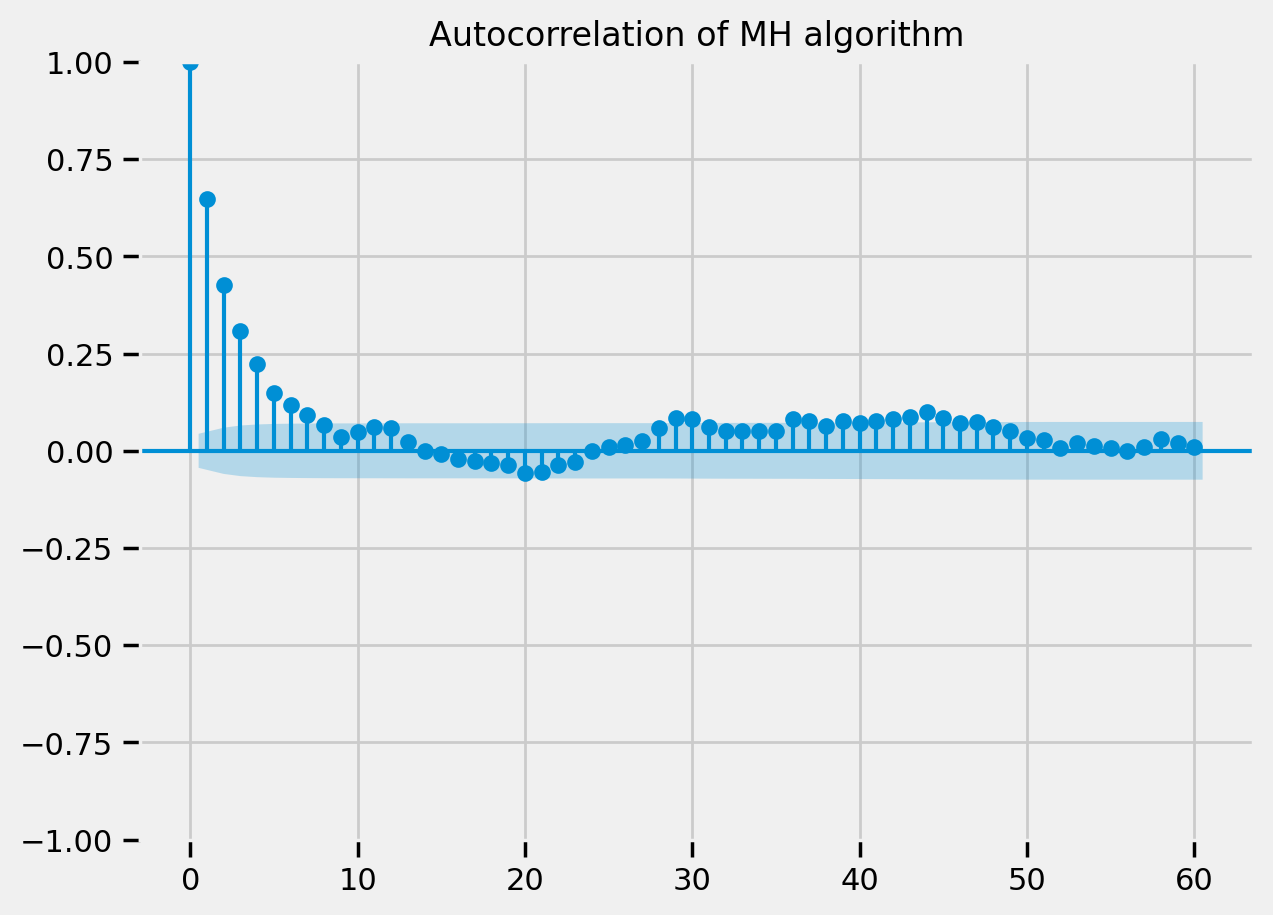

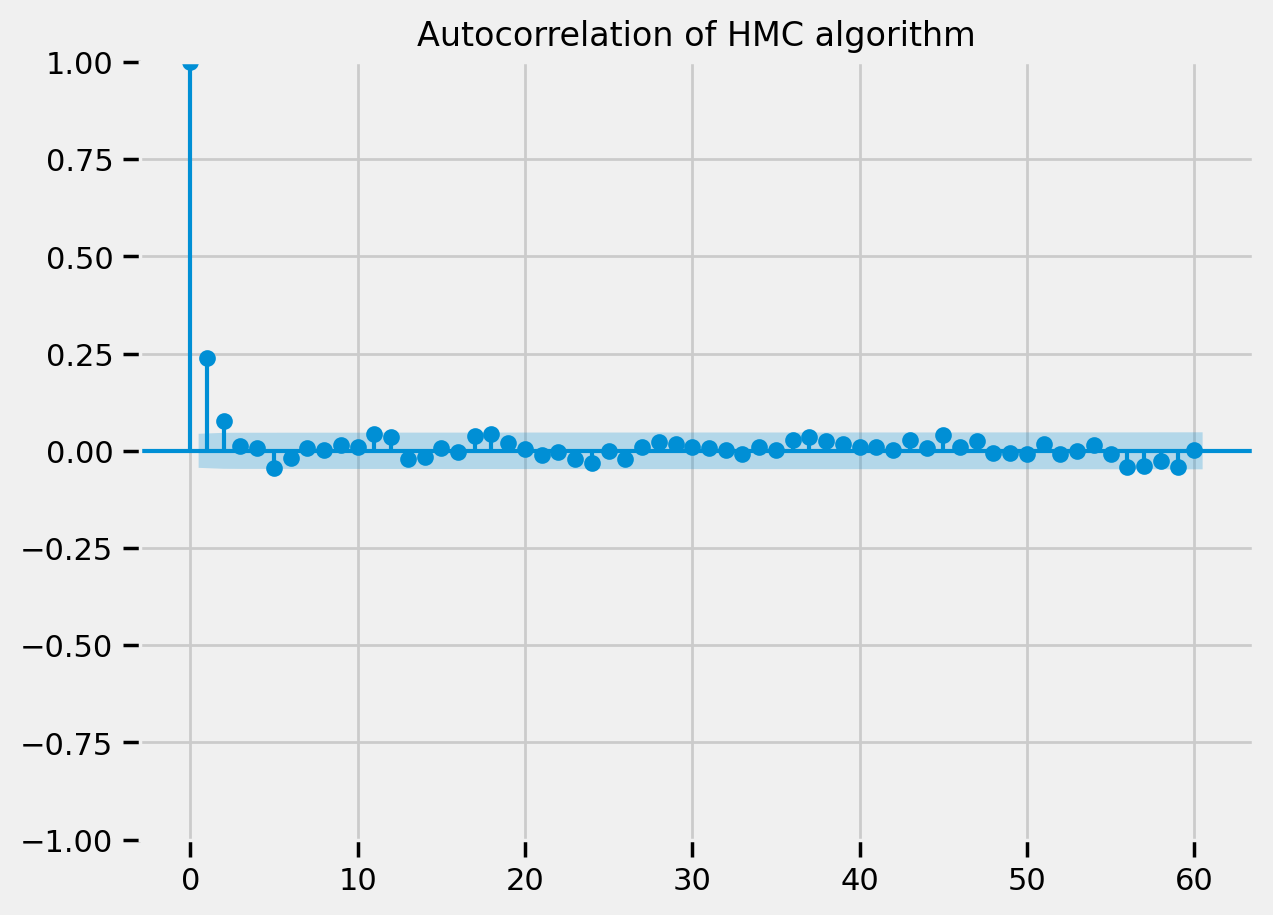

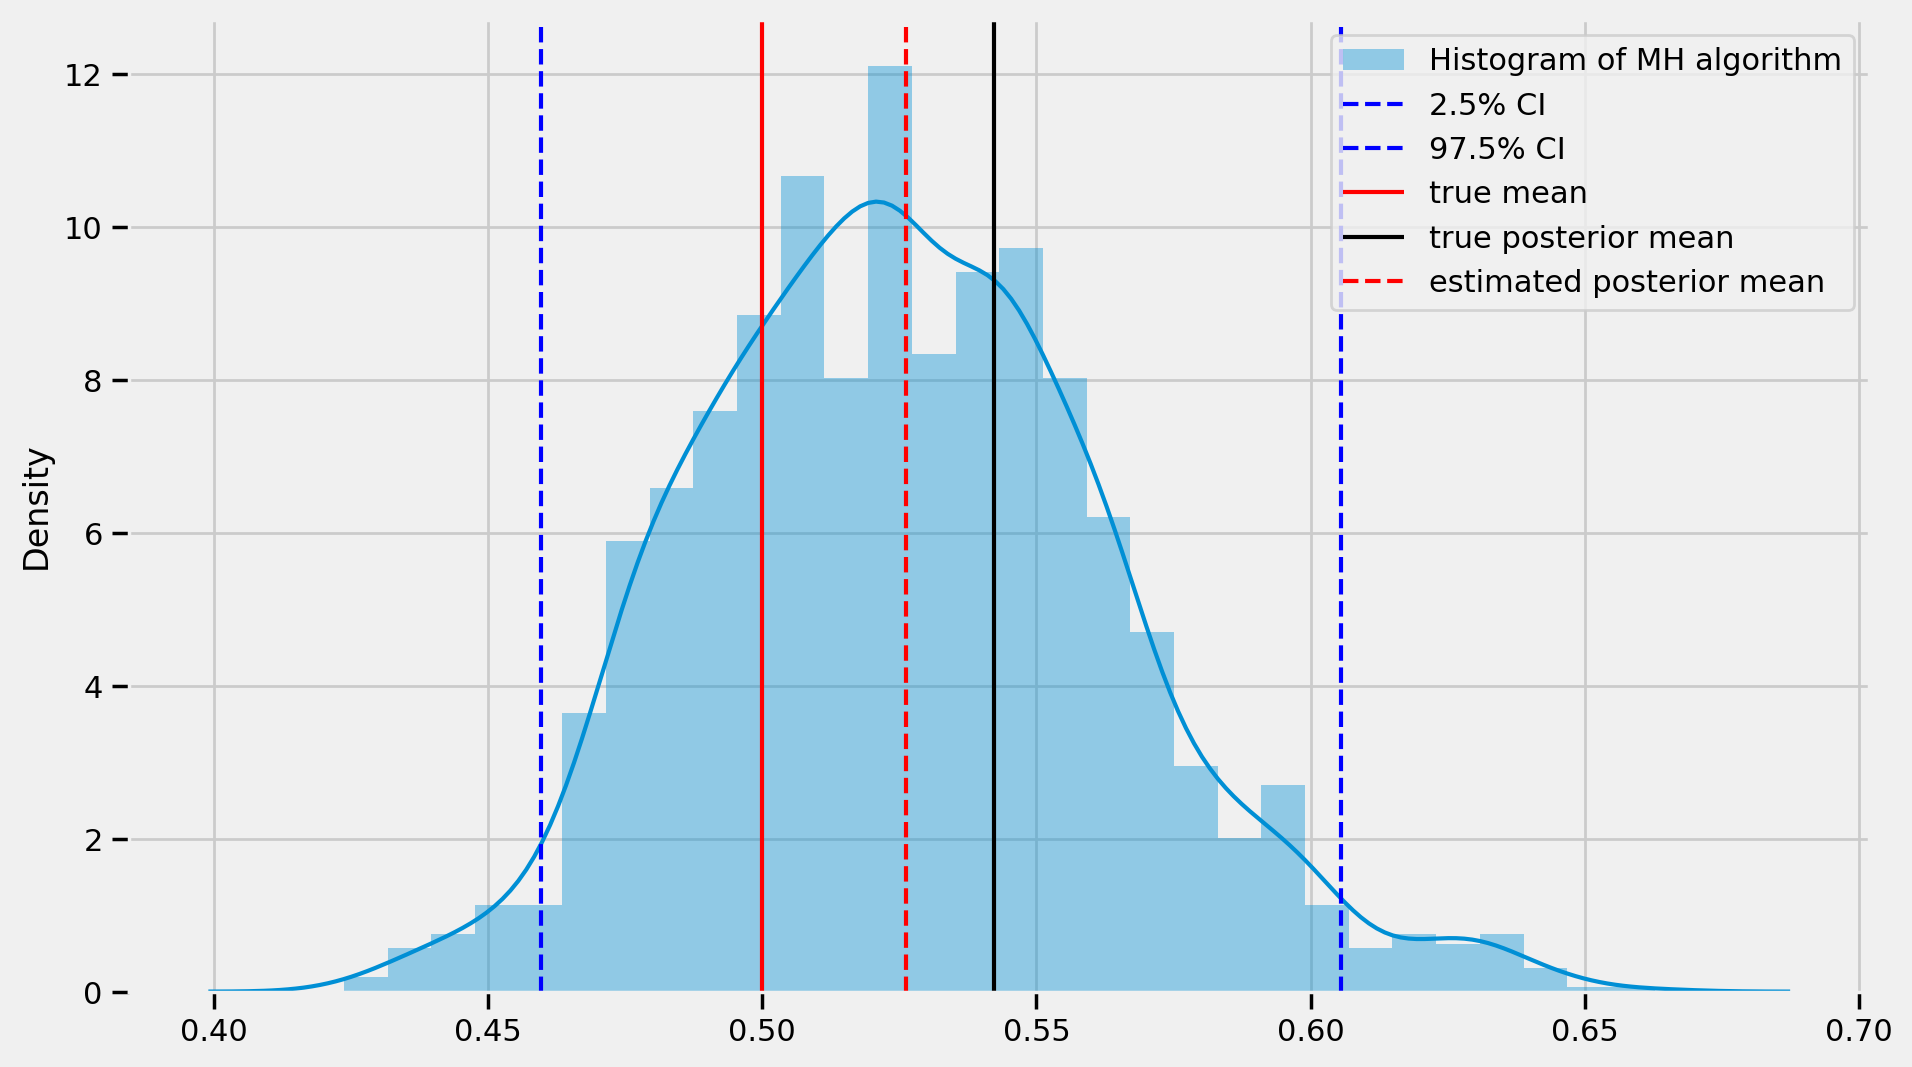

<ipython-input-16-181ff55b3e4a>:34: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(hmc_dist, ax=ax, label='Histogram of HMC algorithm')


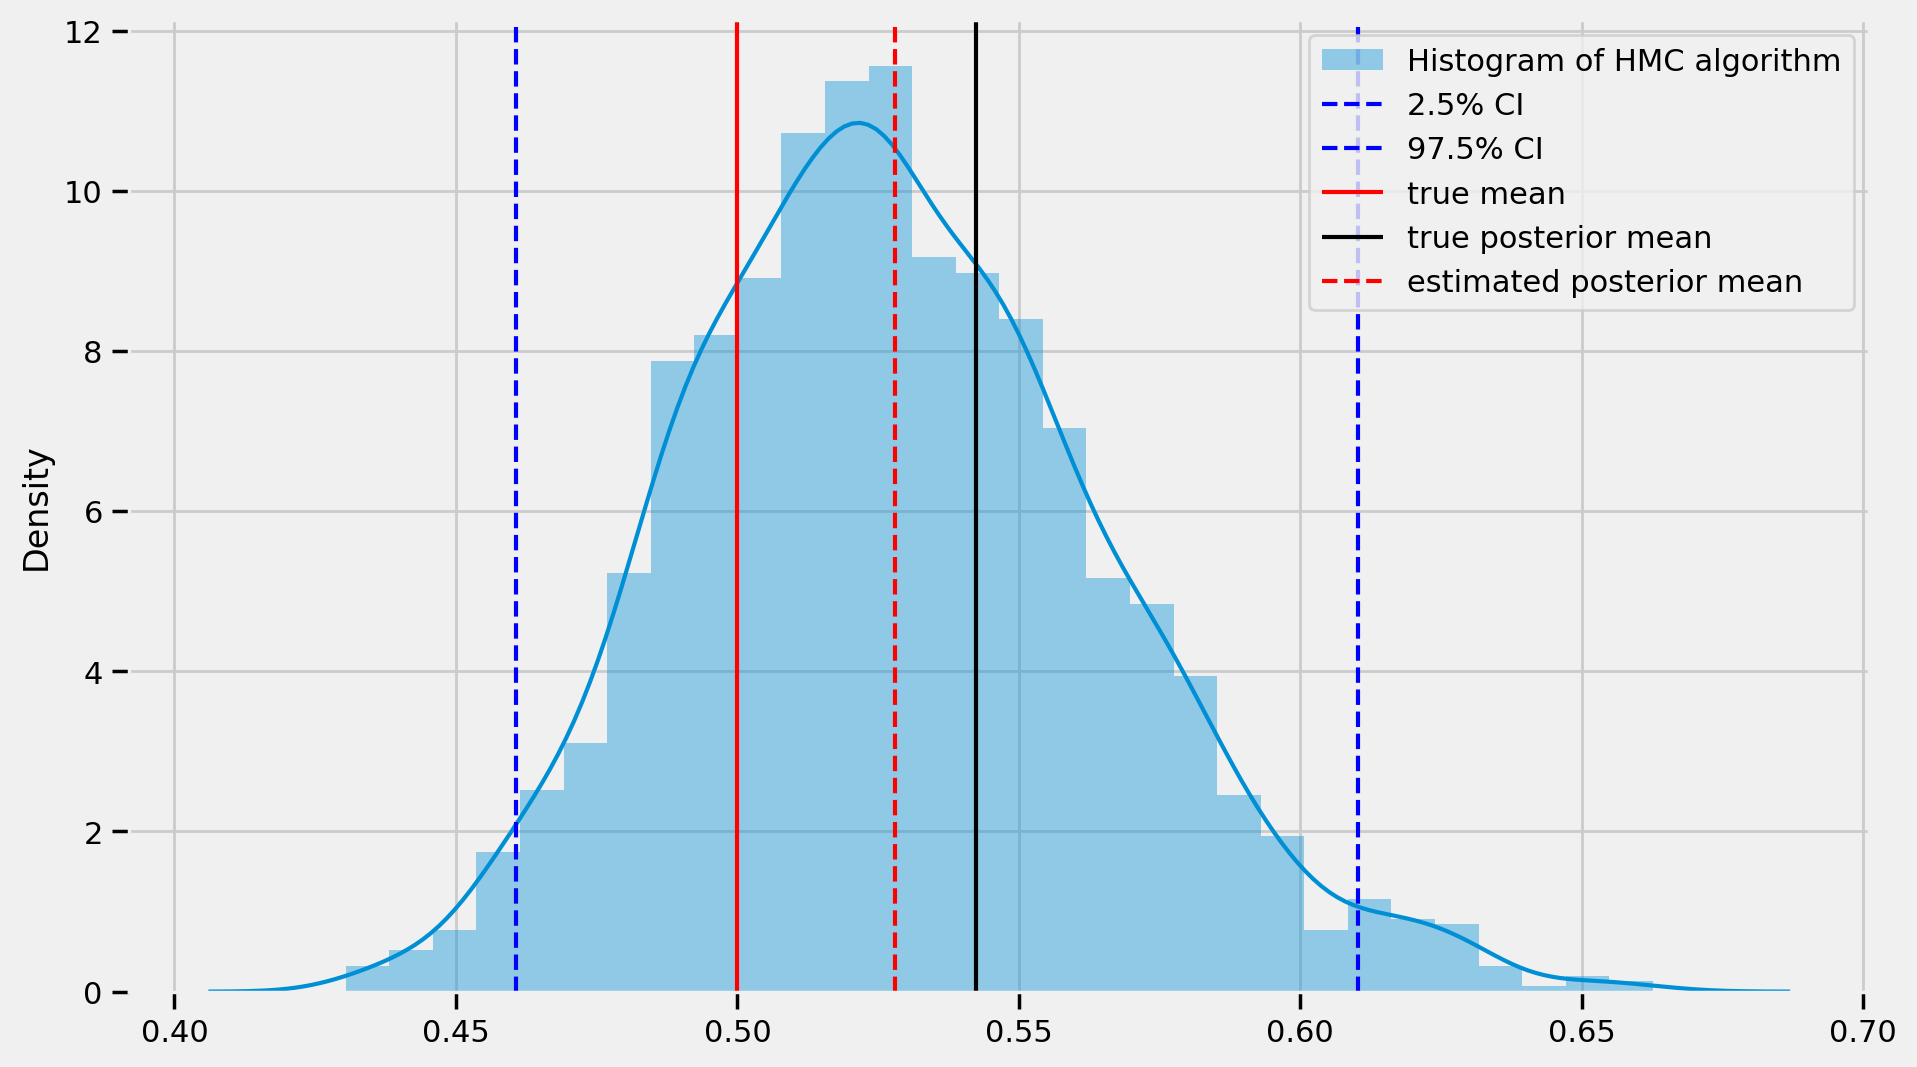

In [16]:
# use the first chain for plotting auto-correlation
sm.graphics.tsa.plot_acf(mh_states[:, 0],
                         title='Autocorrelation of MH algorithm',
                         lags=60)
sm.graphics.tsa.plot_acf(hmc_states[:, 0],
                         title='Autocorrelation of HMC algorithm',
                         lags=60)

# plot the fist chain

mh_dist = mh_states[:, 0]
hmc_dist = hmc_states[:, 0]

# Scatter plot of data samples and histogram
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
sns.distplot(mh_dist, ax=ax, label='Histogram of MH algorithm')
# lines = ax.hist(mh_dist, bins=100, edgecolor="k", label="Histogram of MH algorithm")
ci_mh = credible_interval(mh_dist)
ax.axvline(x=ci_mh[0], color='blue', linestyle='--', label='2.5% CI')
ax.axvline(x=ci_mh[1], color='blue', linestyle='--', label='97.5% CI')
ax.axvline(x=true_std, color='red', linestyle='-', label='true mean')
ax.axvline(x=true_posterior_mean, color='black', linestyle='-', label='true posterior mean')
ax.axvline(x=np.mean(mh_dist), color='red', linestyle='--', label='estimated posterior mean')

ax.legend(loc="best")
ax.grid(True, zorder=-5)
plt.show()


# Scatter plot of data samples and histogram
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
sns.distplot(hmc_dist, ax=ax, label='Histogram of HMC algorithm')
# lines = ax.hist(hmc_dist, bins=100, edgecolor="k", label="Histogram of HMC algorithm")
ci_hmc = credible_interval(hmc_dist)
ax.axvline(x=ci_hmc[0], color='blue', linestyle='--', label='2.5% CI')
ax.axvline(x=ci_hmc[1], color='blue', linestyle='--', label='97.5% CI')
ax.axvline(x=true_std, color='red', linestyle='-', label='true mean')
ax.axvline(x=true_posterior_mean, color='black', linestyle='-', label='true posterior mean')
ax.axvline(x=np.mean(hmc_dist), color='red', linestyle='--', label='estimated posterior mean')

ax.legend(loc="best")
ax.grid(True, zorder=-5)
plt.show()

## Estimation of unknown $\sigma^2$ and $\mu$

Now the problem comes to estimate the joint distribution of $\sigma^2$ and $\mu$.

We can define the prior distribution of $\sigma^2$ as the inverse gamma distribution according to the [conjugate prior](https://en.wikipedia.org/wiki/Conjugate_prior).  That is, $\pi(\sigma^2) \sim \mathcal{IG}(\alpha, \beta)$. And $\pi(\mu) \sim \mathcal{N}(\mu_0, \sigma_0^2)$.

Data likelihood function $l(x|\mu, \sigma^2) = \prod_{i=1} \mathcal{N}(x_i| \mu, \sigma^2)$.

The posterior distribution $p(\sigma^2, \mu| x) ∝ l(x|\mu, \sigma^2)\pi(\sigma^2)\pi(\mu)$ is a Normal-inverse-Gamma distribution (Example 7.3, pp.202-203, [Introducing Monte Carlo Methods with R](https://www.amazon.com/dp/1441915753)).

In [42]:
init_state = tf.random.uniform([N_CHAINS, 1, 2])

"""
In this case, the dimension of sigma is [1,], in order to align the shape with mu
"""

"""
define prior distribution
"""
def prior_dist(parameter):

  return tfd.JointDistributionNamed(dict(
                mu=tfd.Normal(loc=PRIOR_MEAN,
                                  scale=PRIOR_STD),
                sigma=tfd.InverseGamma(concentration=PRIOR_INV_GAMMA_ALPHA,
                                  scale=tf.constant(PRIOR_INV_GAMMA_BETA)))).log_prob({'mu': parameter[..., 0],
                                                                                  'sigma': parameter[..., 1]})

"""
define target distribution
"""
def posterior_dist(observations):
    def _compute_posterior(parameter):
        return tf.reduce_sum(tfd.MultivariateNormalTriL(loc=parameter[..., 0],
                                                        scale_tril=parameter[..., 1:]).log_prob(
            observations), axis=0)[..., tf.newaxis] \
            + prior_dist(parameter)

    return _compute_posterior

"""
Sampling
"""

transformed_bijector = tfb.Blockwise(bijectors=[tfb.Identity(),tfb.Exp()],
                                     block_sizes=[1,1])


@tf.function
def run_metropolis_hasting():
  mh_kernel = RandomWalkMetropolis(posterior_dist(replicate_observations),
                                    new_state_fn=tfp.mcmc.random_walk_normal_fn(scale=0.2))

  states, kernels_results = sample_chain(num_results=num_mcmc_samples,
                                        current_state=init_state, # we use sigma as matrix here
                                        num_burnin_steps=num_burn_in_steps,
                                        num_steps_between_results=0,
                                        kernel=tfp.mcmc.TransformedTransitionKernel(mh_kernel,
                                                                                    bijector=transformed_bijector),
                                        seed=seed)
  return states, kernels_results

@tf.function
def run_hmc():
  hmc_kernel = HamiltonianMonteCarlo(posterior_dist(replicate_observations),
                                    step_size=0.05,
                                    num_leapfrog_steps=2)

  states, kernels_results = sample_chain(num_results=num_mcmc_samples,
                                        current_state=init_state,
                                        num_burnin_steps=num_burn_in_steps,
                                        kernel=tfp.mcmc.TransformedTransitionKernel(hmc_kernel,
                                                                                    bijector=transformed_bijector),
                                        seed=seed)

  return states, kernels_results

mh_states, mh_results = run_metropolis_hasting()
hmc_states, hmc_results = run_hmc()

mh_states_mean = tf.squeeze(mh_states[..., 0], axis=[-1]).numpy()
mh_states_std = tf.squeeze(mh_states[..., 1], axis=[-1]).numpy()
hmc_states_mean = tf.squeeze(hmc_states[..., 0], axis=[-1]).numpy()
hmc_states_std = tf.squeeze(hmc_states[..., 1], axis=[-1]).numpy()



/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/mcmc/sample.py:339: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '
/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/mcmc/sample.py:339: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '


In [43]:
#@title Diagonics For Mean { display-mode: "form" }

r_hat_mh = tfp.mcmc.potential_scale_reduction(
    mh_states_mean,
    independent_chain_ndims=1,
    split_chains=True)
r_hat_hmc = tfp.mcmc.potential_scale_reduction(
    hmc_states_mean,
    independent_chain_ndims=1,
    split_chains=True)

print(f"R^hat for MH algorithm {r_hat_mh}")
print(f"R^hat for HMC algorithm {r_hat_hmc}")

accept_rate_mh = tf.math.count_nonzero(mh_results.inner_results.is_accepted, axis=0)/num_mcmc_samples
accept_rate_hmc = tf.math.count_nonzero(hmc_results.inner_results.is_accepted, axis=0)/num_mcmc_samples

print(f"Acceptance rate for MH algorithm {accept_rate_mh}")
print(f"Acceptance rate for HMC algorithm {accept_rate_hmc}")

ess_mh = tfp.mcmc.effective_sample_size(
    mh_states_mean,
    cross_chain_dims=None,
)
ess_hmc = tfp.mcmc.effective_sample_size(
    hmc_states_mean,
    cross_chain_dims=None,
)

print(f"Effective sample size for MH algorithm {ess_mh}")
print(f"Effective sample size for HMC algorithm {ess_hmc}")



R^hat for MH algorithm 1.00468111038208
R^hat for HMC algorithm 0.9999045729637146
Acceptance rate for MH algorithm [[0.155 ]
 [0.1425]
 [0.157 ]
 [0.1555]
 [0.1435]
 [0.1515]
 [0.144 ]
 [0.1495]]
Acceptance rate for HMC algorithm [[0.9025]
 [0.917 ]
 [0.914 ]
 [0.909 ]
 [0.896 ]
 [0.9015]
 [0.9095]
 [0.9165]]
Effective sample size for MH algorithm [128.9435  161.46262 215.08936 182.79648 192.58488 204.65718 189.21764
 128.72458]
Effective sample size for HMC algorithm [2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000.]


<ipython-input-44-4b698900201a>:17: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(mh_dist, ax=ax, label='Histogram of MH algorithm')


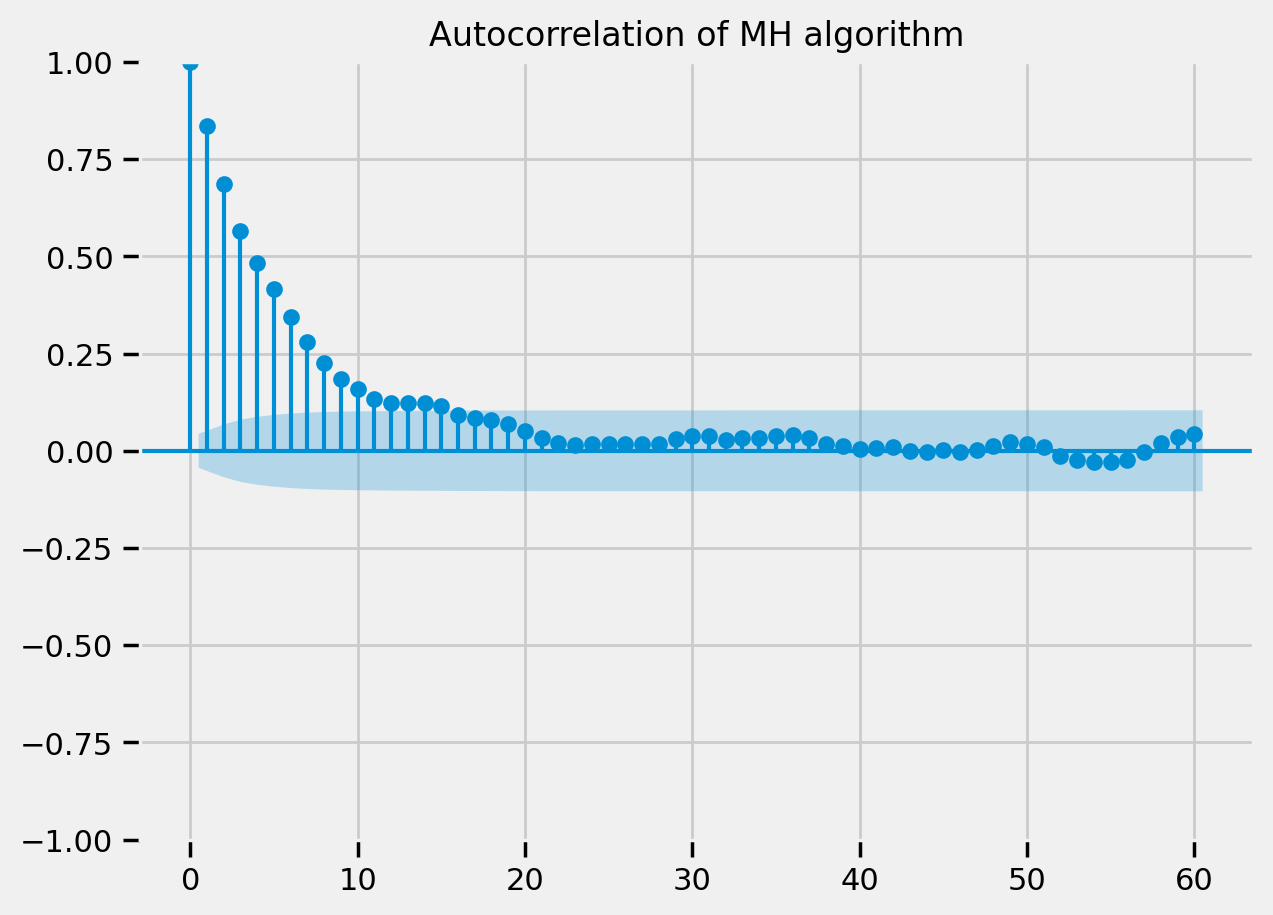

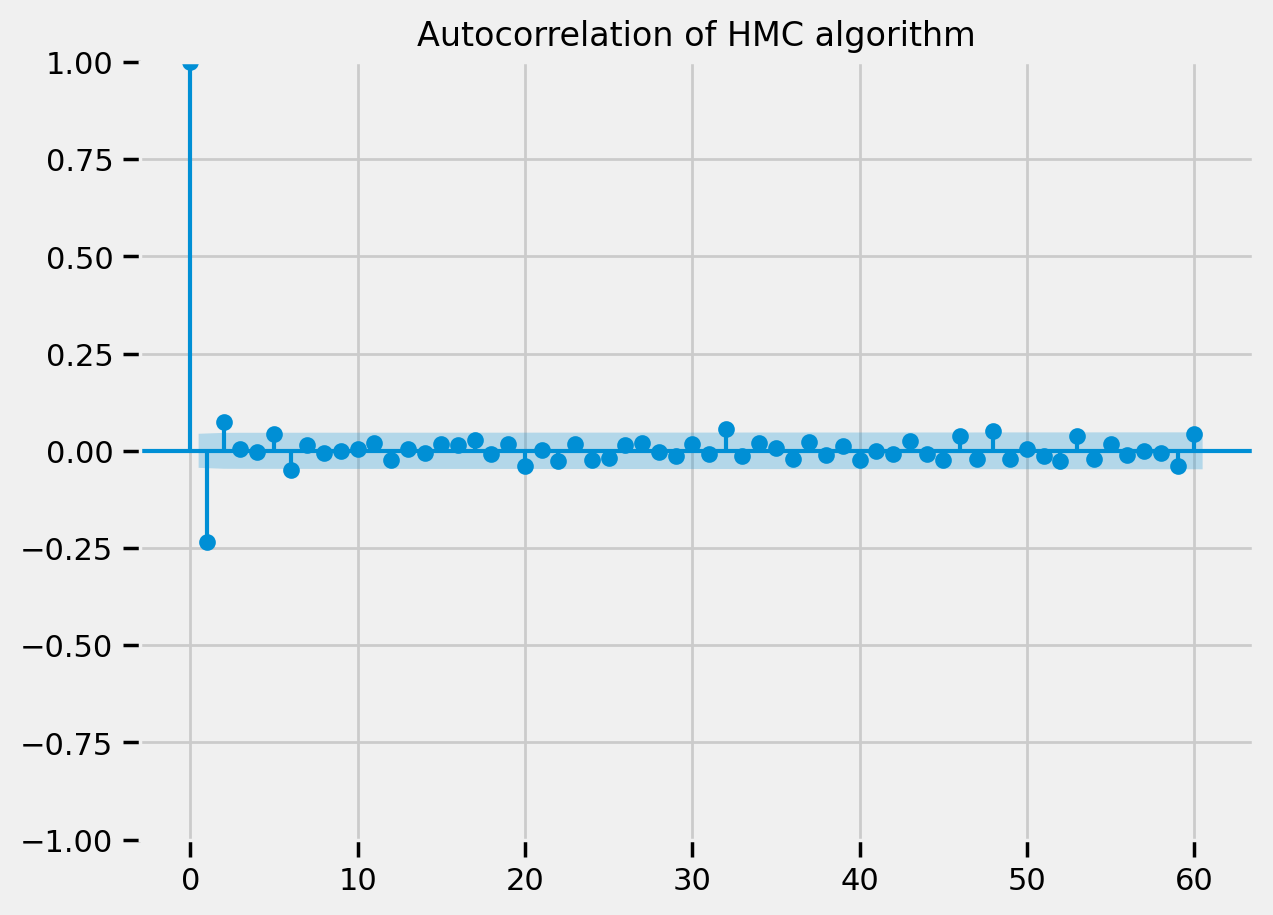

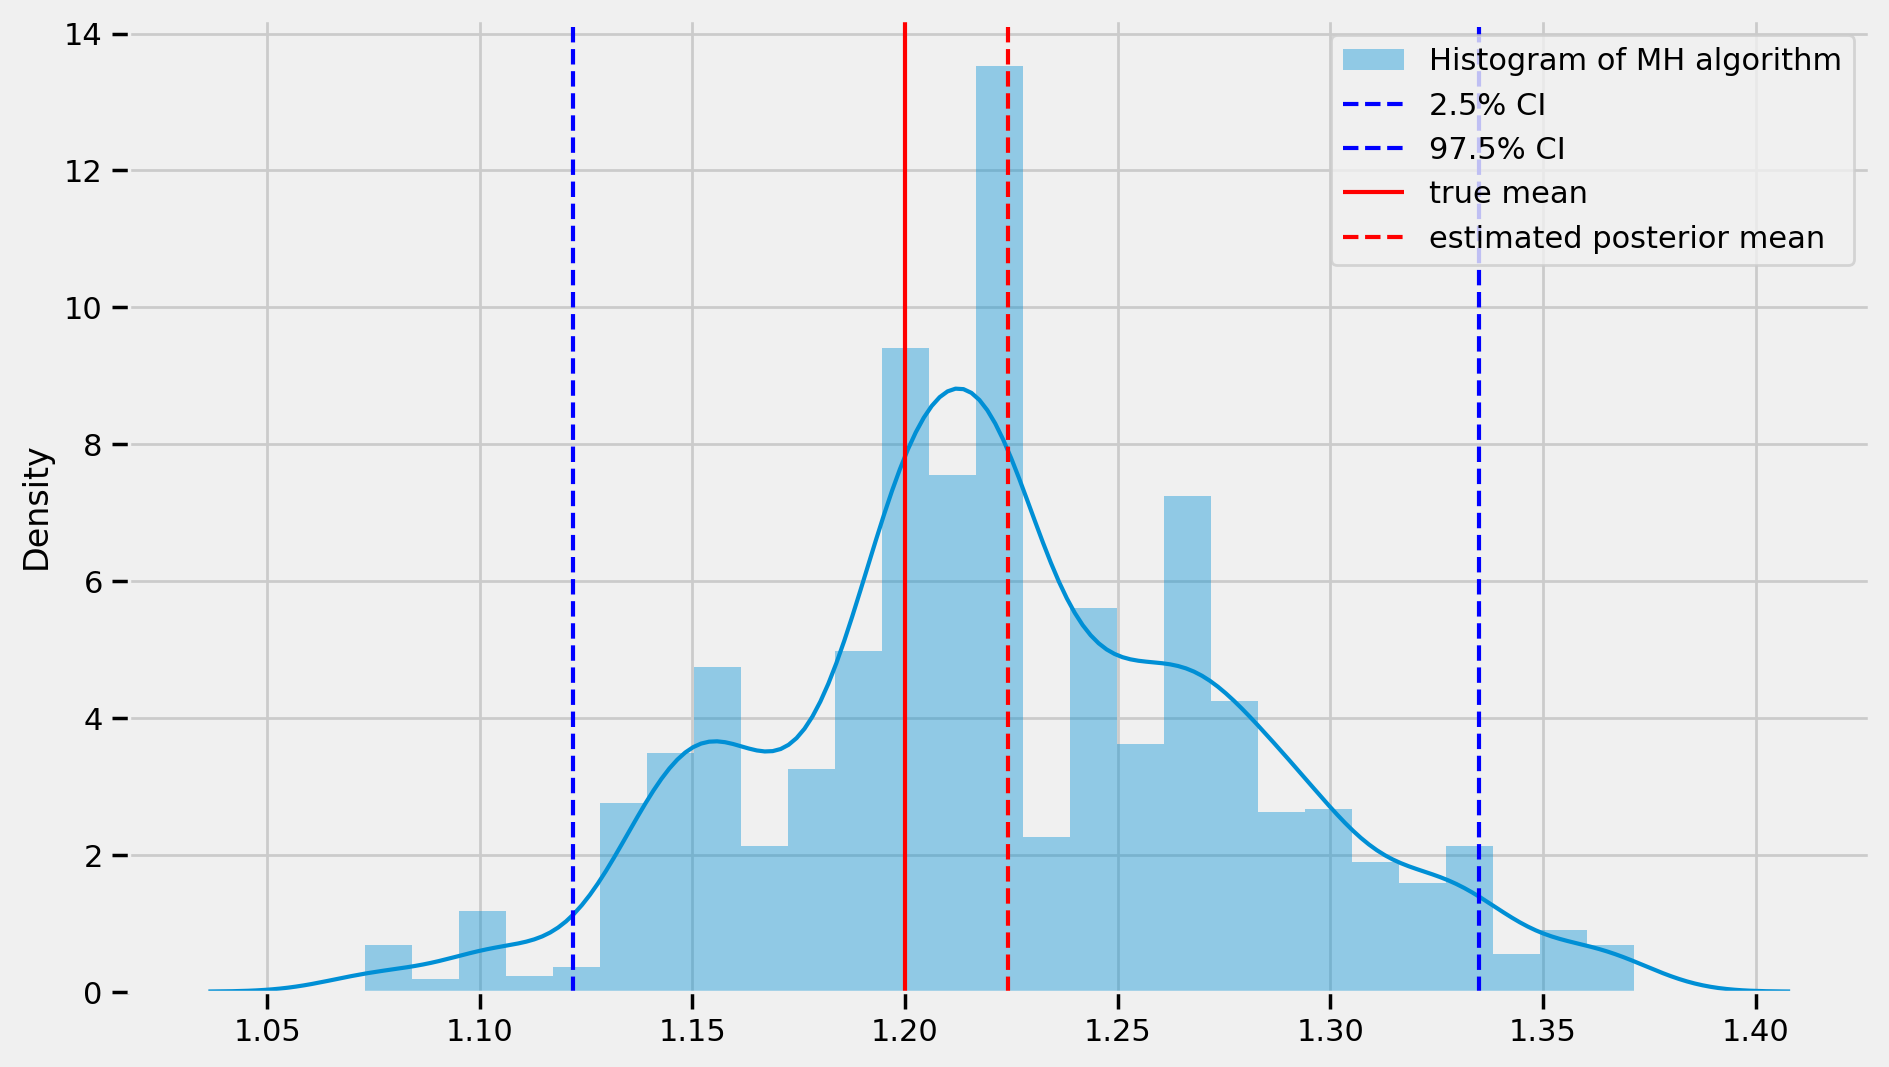

<ipython-input-44-4b698900201a>:33: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(hmc_dist, ax=ax, label='Histogram of HMC algorithm')


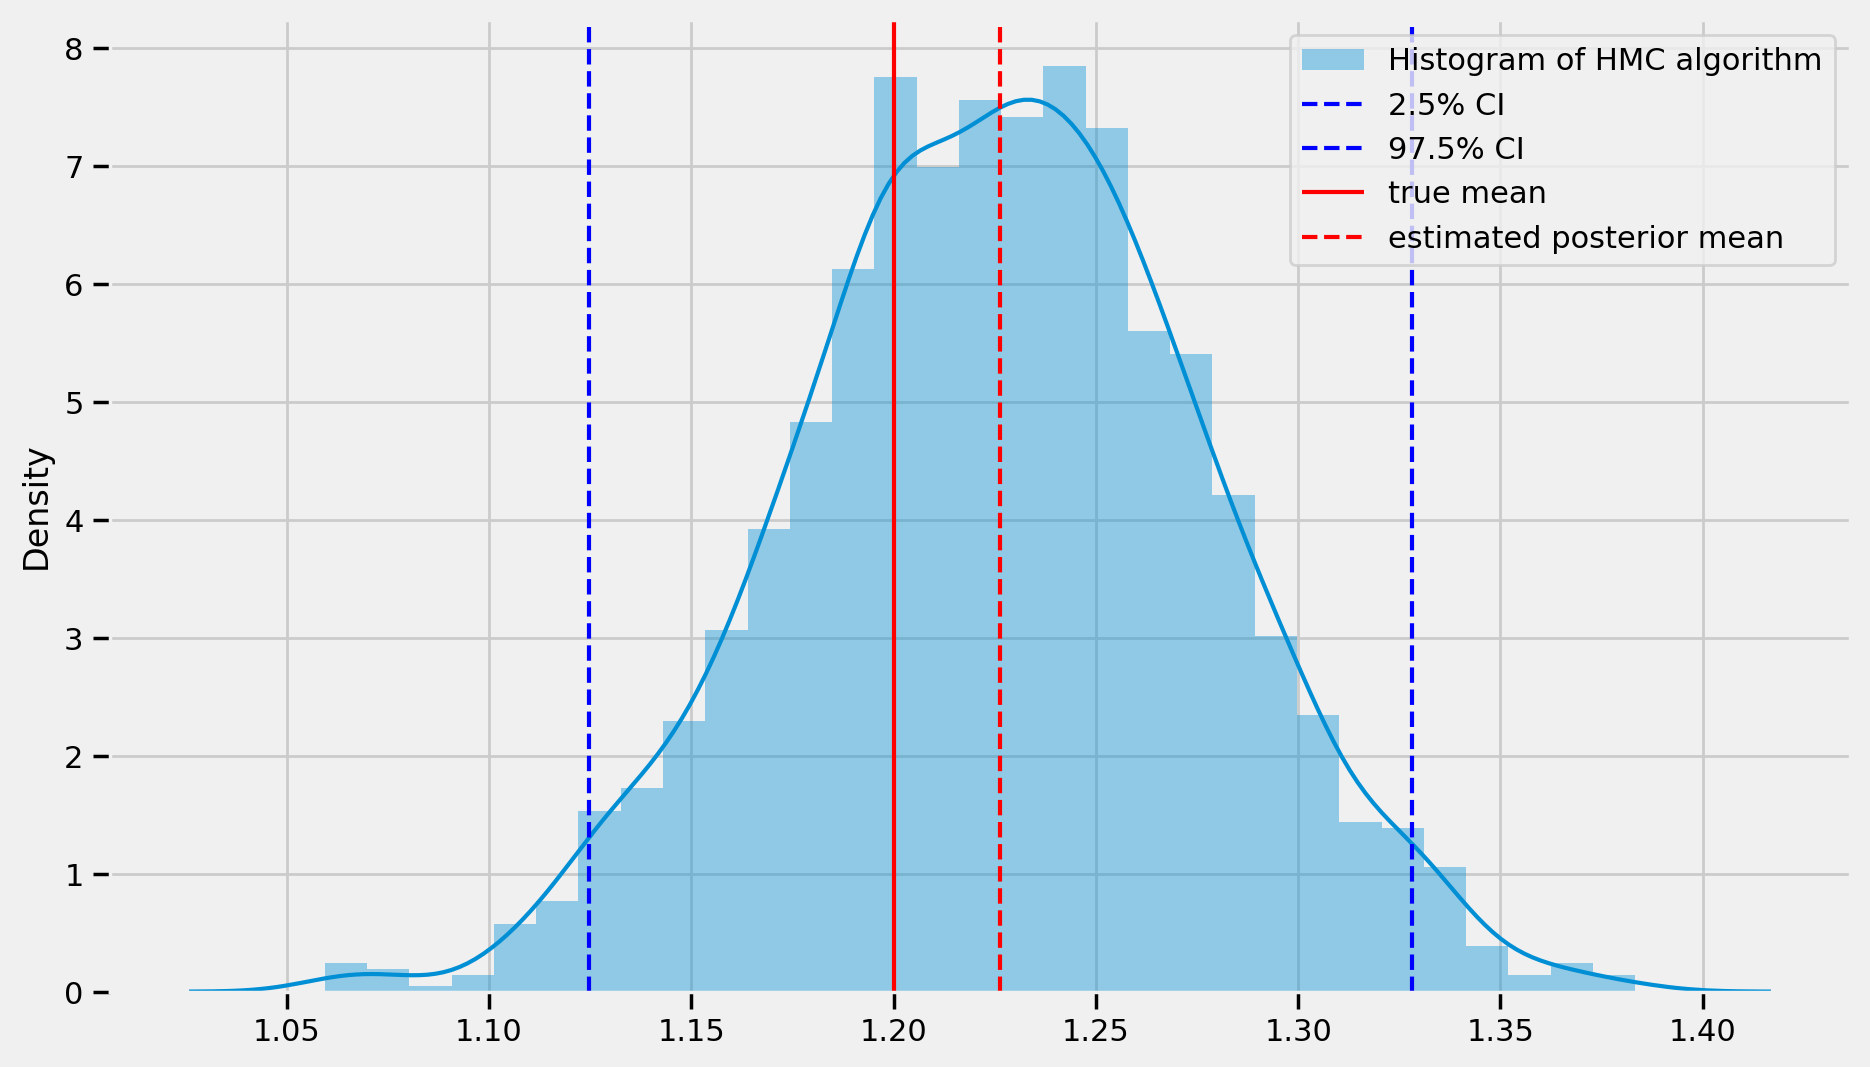

In [44]:
# use the first chain for plotting auto-correlation
sm.graphics.tsa.plot_acf(mh_states_mean[:, 1],
                         title='Autocorrelation of MH algorithm',
                         lags=60)
sm.graphics.tsa.plot_acf(hmc_states_mean[:, 1],
                         title='Autocorrelation of HMC algorithm',
                         lags=60)

# plot the fist chain

mh_dist = mh_states_mean[:, 1]
hmc_dist = hmc_states_mean[:, 1]

# Scatter plot of data samples and histogram
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
sns.distplot(mh_dist, ax=ax, label='Histogram of MH algorithm')
# lines = ax.hist(mh_dist, bins=100, edgecolor="k", label="Histogram of MH algorithm")
ci_mh = credible_interval(mh_dist)
ax.axvline(x=ci_mh[0], color='blue', linestyle='--', label='2.5% CI')
ax.axvline(x=ci_mh[1], color='blue', linestyle='--', label='97.5% CI')
ax.axvline(x=true_mean, color='red', linestyle='-', label='true mean')
ax.axvline(x=np.mean(mh_dist), color='red', linestyle='--', label='estimated posterior mean')

ax.legend(loc="best")
ax.grid(True, zorder=-5)
plt.show()


# Scatter plot of data samples and histogram
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
sns.distplot(hmc_dist, ax=ax, label='Histogram of HMC algorithm')
# lines = ax.hist(hmc_dist, bins=100, edgecolor="k", label="Histogram of HMC algorithm")
ci_hmc = credible_interval(hmc_dist)
ax.axvline(x=ci_hmc[0], color='blue', linestyle='--', label='2.5% CI')
ax.axvline(x=ci_hmc[1], color='blue', linestyle='--', label='97.5% CI')
ax.axvline(x=true_mean, color='red', linestyle='-', label='true mean')
ax.axvline(x=np.mean(hmc_dist), color='red', linestyle='--', label='estimated posterior mean')

ax.legend(loc="best")
ax.grid(True, zorder=-5)
plt.show()

In [45]:
#@title Diagonics For Variance { display-mode: "form" }

r_hat_mh = tfp.mcmc.potential_scale_reduction(
    mh_states_std,
    independent_chain_ndims=1,
    split_chains=True)
r_hat_hmc = tfp.mcmc.potential_scale_reduction(
    hmc_states_std,
    independent_chain_ndims=1,
    split_chains=True)

print(f"R^hat for MH algorithm {r_hat_mh}")
print(f"R^hat for HMC algorithm {r_hat_hmc}")

ess_mh = tfp.mcmc.effective_sample_size(
    mh_states_std,
    cross_chain_dims=None,
)
ess_hmc = tfp.mcmc.effective_sample_size(
    hmc_states_std,
    cross_chain_dims=None,
)

print(f"Effective sample size for MH algorithm {ess_mh}")
print(f"Effective sample size for HMC algorithm {ess_hmc}")



R^hat for MH algorithm 1.006990671157837
R^hat for HMC algorithm 1.0005757808685303
Effective sample size for MH algorithm [144.46585 150.13768 168.37411 138.93884 164.81355 195.68202 114.70317
 174.00626]
Effective sample size for HMC algorithm [1385.5199 1329.433  1308.2775 1375.6045 1332.3773 1254.6472 1075.5912
 1251.3423]


<ipython-input-46-69a71ab698c2>:17: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(mh_dist, ax=ax, label='Histogram of MH algorithm')


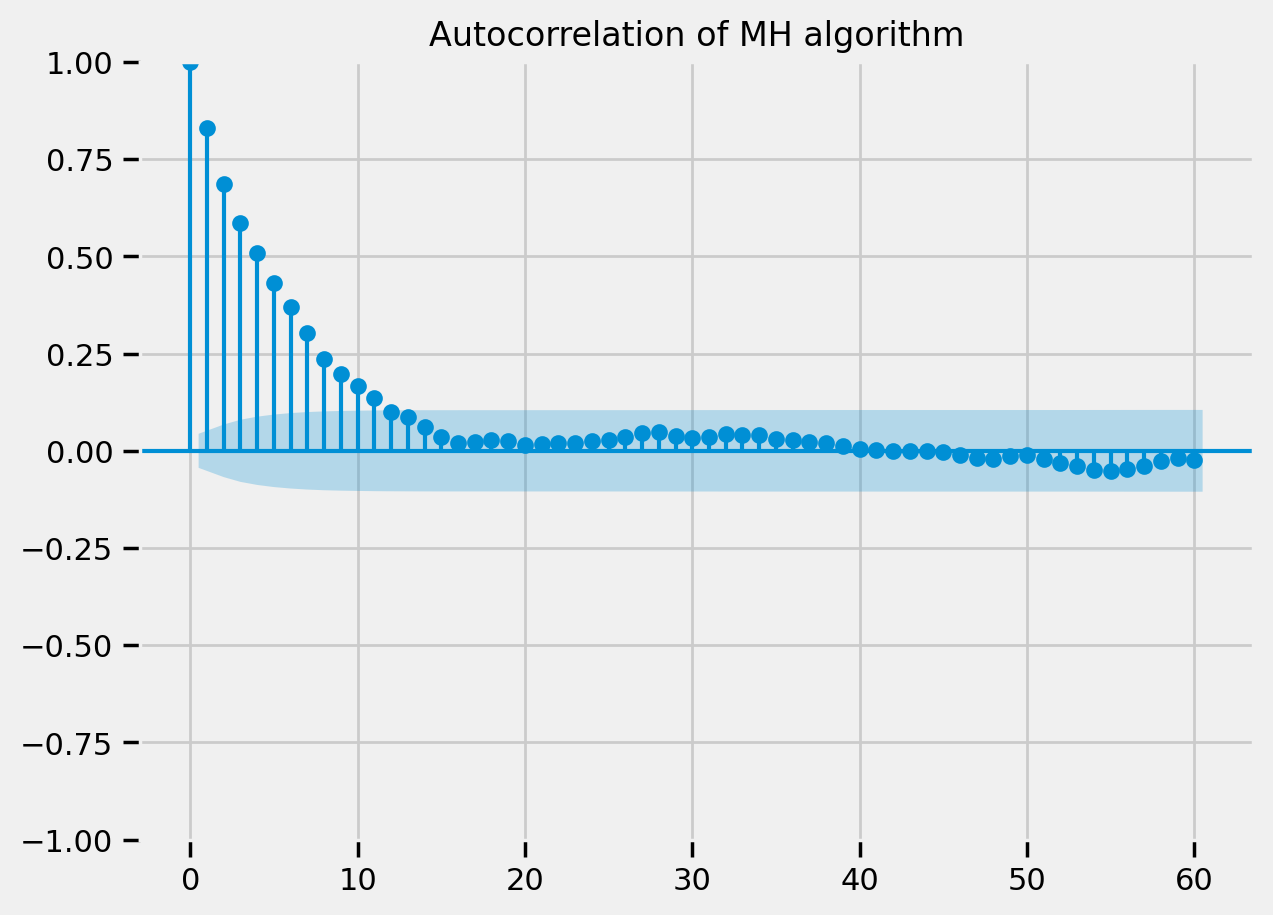

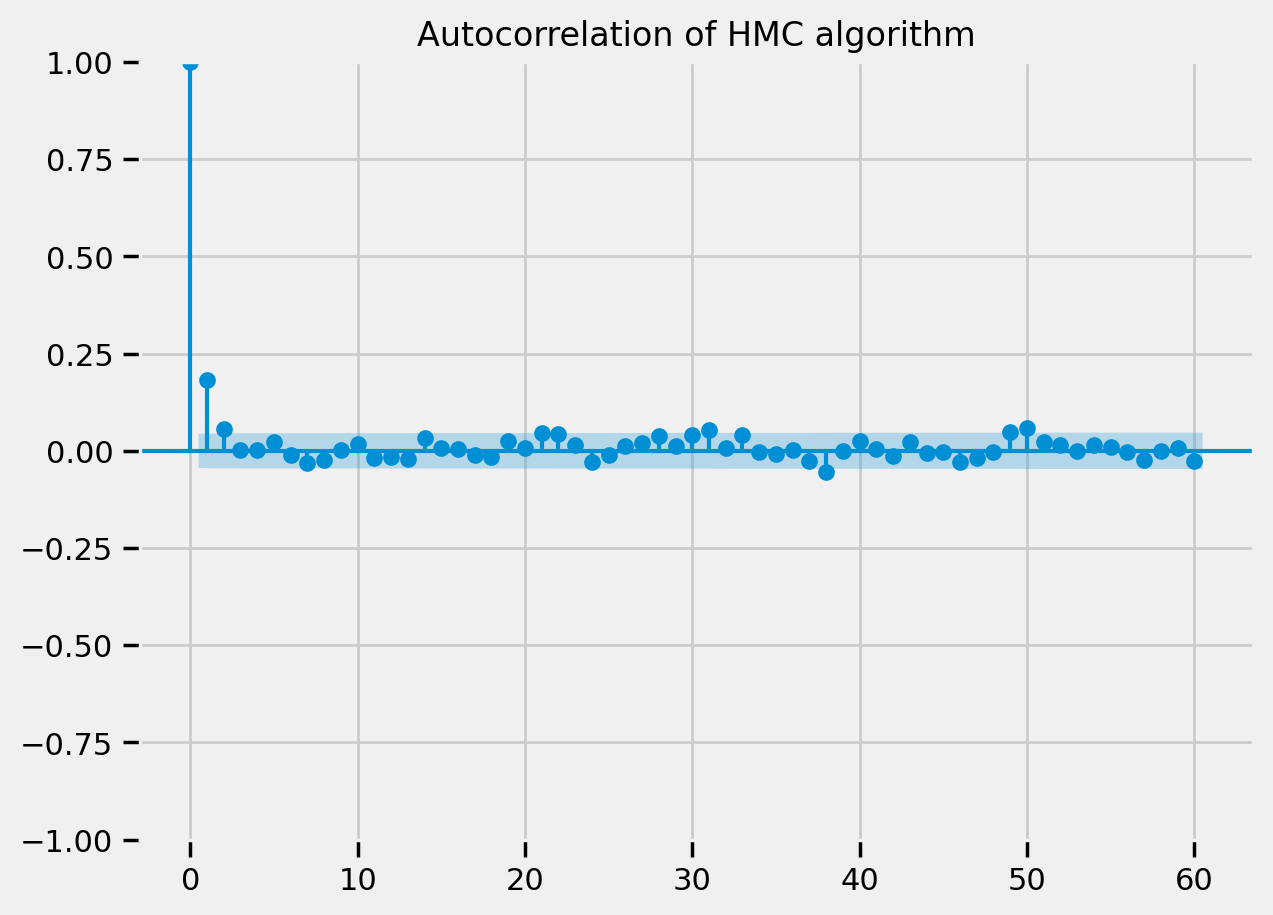

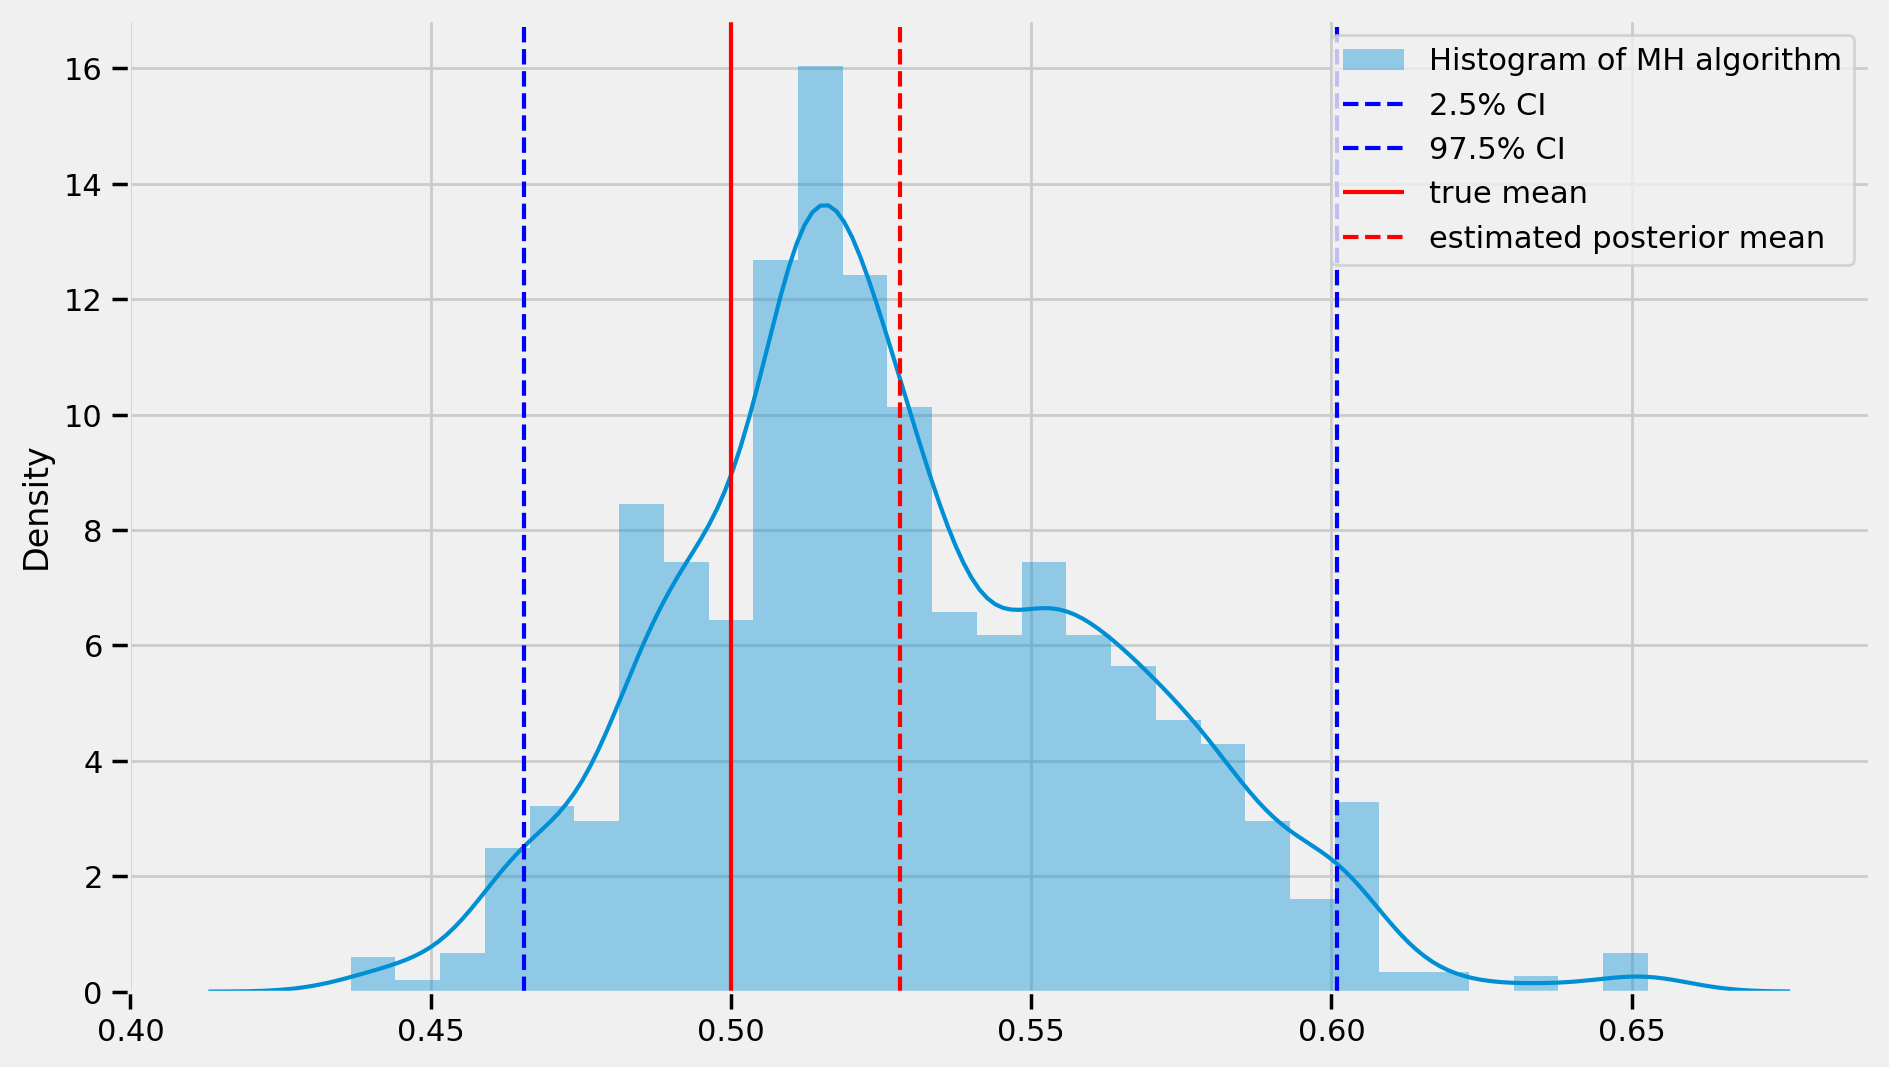

<ipython-input-46-69a71ab698c2>:33: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(hmc_dist, ax=ax, label='Histogram of HMC algorithm')


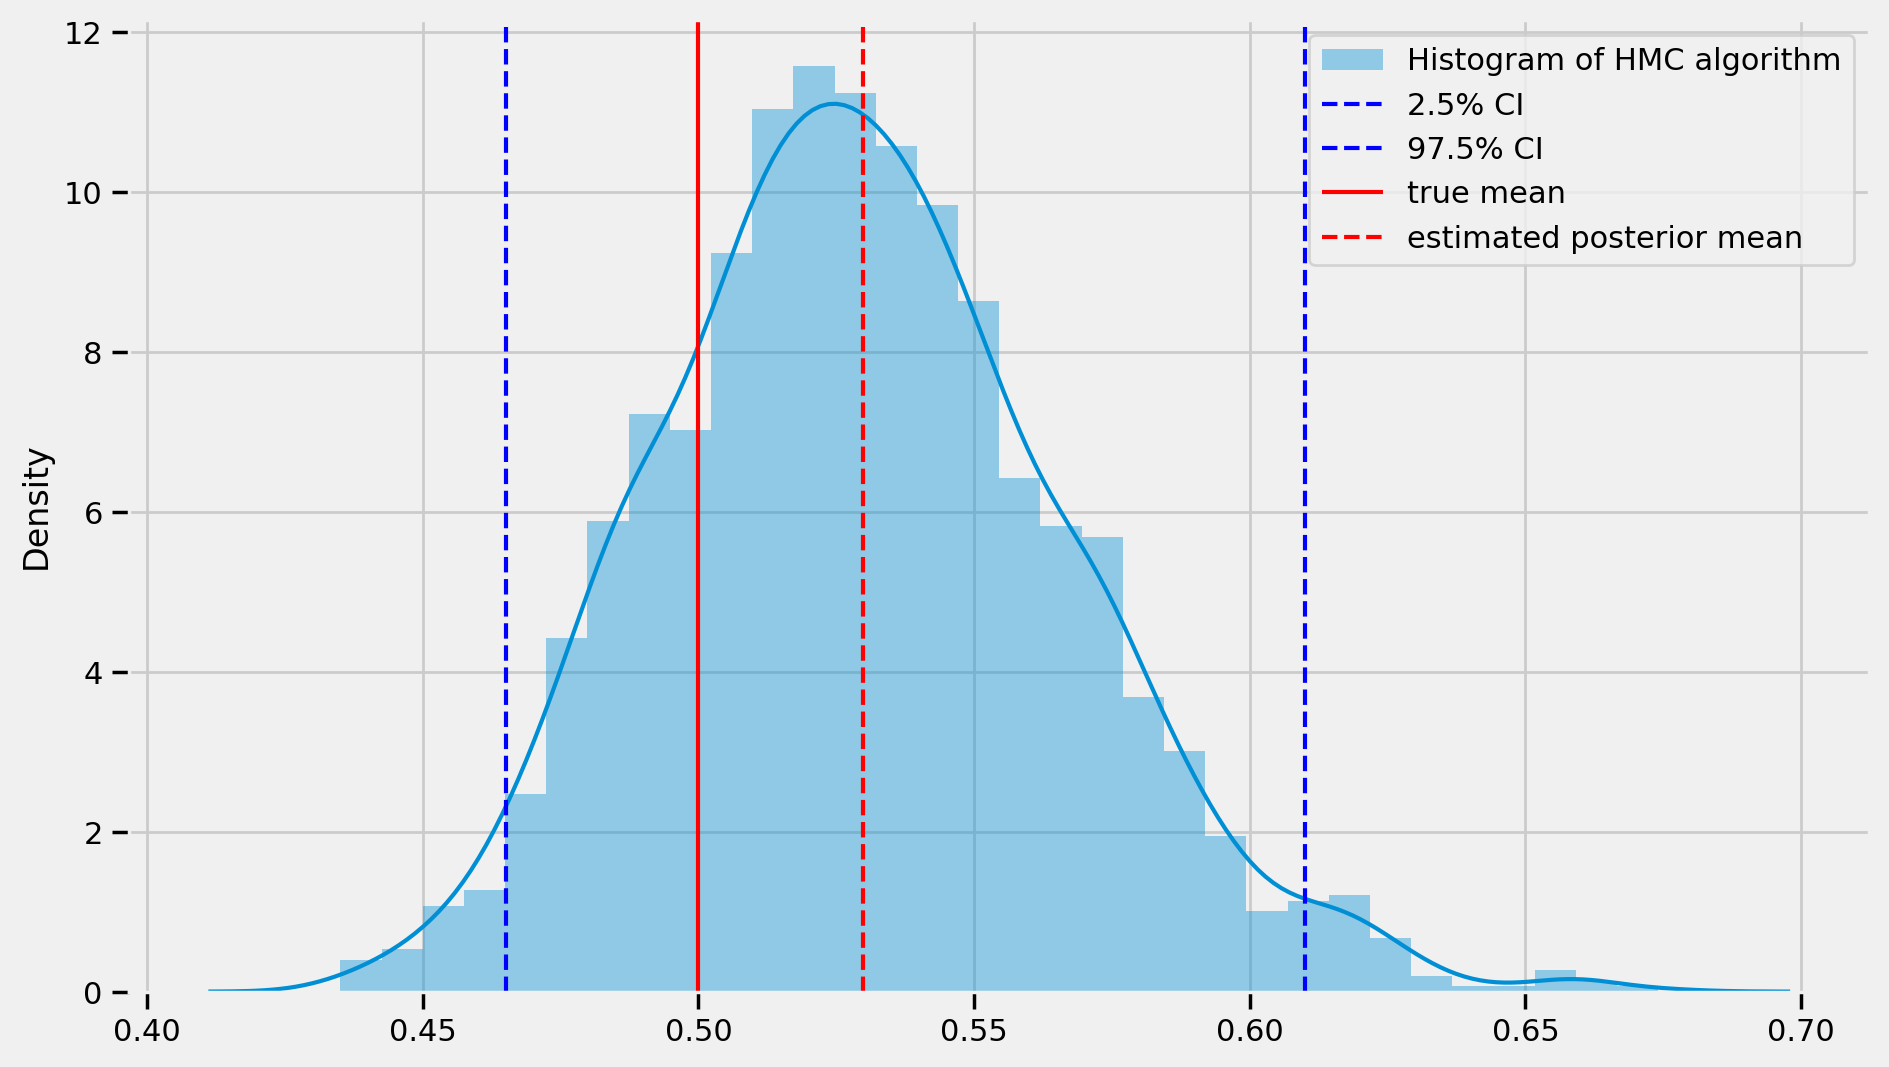

In [46]:
# use the first chain for plotting auto-correlation
sm.graphics.tsa.plot_acf(mh_states_std[:, 2],
                         title='Autocorrelation of MH algorithm',
                         lags=60)
sm.graphics.tsa.plot_acf(hmc_states_std[:, 2],
                         title='Autocorrelation of HMC algorithm',
                         lags=60)

# plot the fist chain

mh_dist = mh_states_std[:, 2]
hmc_dist = hmc_states_std[:, 2]

# Scatter plot of data samples and histogram
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
sns.distplot(mh_dist, ax=ax, label='Histogram of MH algorithm')
# lines = ax.hist(mh_dist, bins=100, edgecolor="k", label="Histogram of MH algorithm")
ci_mh = credible_interval(mh_dist)
ax.axvline(x=ci_mh[0], color='blue', linestyle='--', label='2.5% CI')
ax.axvline(x=ci_mh[1], color='blue', linestyle='--', label='97.5% CI')
ax.axvline(x=true_std, color='red', linestyle='-', label='true mean')
ax.axvline(x=np.mean(mh_dist), color='red', linestyle='--', label='estimated posterior mean')

ax.legend(loc="best")
ax.grid(True, zorder=-5)
plt.show()


# Scatter plot of data samples and histogram
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
sns.distplot(hmc_dist, ax=ax, label='Histogram of HMC algorithm')
# lines = ax.hist(hmc_dist, bins=100, edgecolor="k", label="Histogram of HMC algorithm")
ci_hmc = credible_interval(hmc_dist)
ax.axvline(x=ci_hmc[0], color='blue', linestyle='--', label='2.5% CI')
ax.axvline(x=ci_hmc[1], color='blue', linestyle='--', label='97.5% CI')
ax.axvline(x=true_std, color='red', linestyle='-', label='true mean')
ax.axvline(x=np.mean(hmc_dist), color='red', linestyle='--', label='estimated posterior mean')

ax.legend(loc="best")
ax.grid(True, zorder=-5)
plt.show()